## Librerías

In [1]:
from collections import Counter
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
from tqdm import tqdm

## Constantes Globales

In [2]:
# Clasificacion
ARRANGED_CLASSES_CLASSIFICATION = [
    "civilian aircraft",
    "civilian car",
    "military aircraft",
    "military helicopter",
    "military tank",
    "military truck"
]
COLORS_CLASSIFICATION = ["blue", "orange", "green", "red", "purple", "brown"]

# Deteccion de Objetos
OD_CLASS_DICT = {
    0: "Tank (TANK)",
    1: "Infantry fighting vehicle (IFV)",
    2: "Armored personnel carrier (APC)",
    3: "Engineering vehicle (EV)",
    4: "Assault helicopter (AH)",
    5: "Transport helicopter (TH)",
    6: "Assault airplane (AAP)",
    7: "Transport airplane (TA)",
    8: "Anti-aircraft vehicle (AA)",
    9: "Towed artillery (TART)",
    10: "Self-propelled artillery (SPART)",
}

OD_CLASSES = [OD_CLASS_DICT[i] for i in range(11)]

OD_COLORS = ["red", "blue", "green", "orange", "purple", "yellow", "cyan", "magenta", "pink", "brown", "grey", "darkgreen"]

# Segmentacion Semantica
SS_CLASSES = pd.read_csv("datasets/ss_dataset/train/img_02177.csv")[" Class"].values[1:9]

SS_COLORS = [
   ( 65/255, 105/255, 225/255), # Clase 1 (RU_airforce)
   (  0/255,   0/255, 128/255), # Clase 2 (RU_army)
   (  0/255, 191/255, 255/255), # Clase 3 (RU_marines)
   ( 70/255, 130/255, 180/255), # Clase 4 (RU_navy)
   (220/255,  20/255,  60/255), # Clase 5 (US_airforce)
   (255/255,  36/255,   0/255), # Clase 6 (US_army)
   (128/255,   0/255,  32/255), # Clase 7 (US_marines)
   (255/255, 166/255, 150/255) # Clase 8 (US_airforce)
]

## Funciones Auxiliares

In [16]:
def classification_plot(class_counts, classes, colors, title):
    """
    Elabora una grafica de barras con la distribución de las clases de las imágenes
    de un conjunto de datos.
    """
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(classes, class_counts["count"], color=colors)
    ax.set_title(title, fontsize=25)
    ax.set_ylabel("Número de Imágenes", fontsize=15)
    fig.tight_layout()

    # Rotamos las etiquetas del eje x
    plt.xticks(ax.get_xticks(), classes, rotation=90, fontsize=20)
    
    plt.show()

    return fig


def od_plot(od_df, classes, colors, title):
    """
    Elabora una gráfica conjunta con la distribución de los objetos en clases de un dataset,
    un mapa de calor de sus centros normalizados y una scatterplot de sus alturas 
    normalizadas frente a sus anchuras normalizadas.
    """

    # Contabiliamos cuantos objetos de cada clase hay
    count_df = od_df["class"].value_counts().reindex(classes, fill_value=0).reset_index()

    fig, axs = plt.subplots(1, 3, figsize=(20, 11.5))
    
    # Gráfica de Barras
    tick_locs = np.arange(11) # Posicion de las marcas del eje x

    axs[0].bar(count_df["class"], count_df["count"], color=colors)
    axs[0].set_xticks(tick_locs)
    _ = axs[0].set_xticklabels(count_df["class"], rotation=90, fontsize=18)
    axs[0].tick_params(axis="y", labelsize=18)
    axs[0].set_ylabel("Número de Objetos", fontsize=21)
    axs[0].set_title("Distribución de los Objetos\n de Cada Clase", fontsize=27)
    
    # Mapa de Calor
    x_min = round(od_df["x0"].min(), 1)
    x_max = round(od_df["x0"].max(), 1)
    y_min = round(od_df["y0"].min(), 1)
    y_max = round(od_df["y0"].max(), 1)
    tick_vals = np.round(np.arange(0, 1.01, 0.05), 2) # Marcas de los ejes
    tick_vals = tick_vals.astype(str)
    tick_vals[1::2] = "" # Solo hay un numero cada dos marcas
    tick_locs = np.linspace(0, 20, len(tick_vals)) # Posiciones de las marcas

    heatmap, _, _ = np.histogram2d(
        od_df["y0"],
        od_df["x0"],
        bins=[20, 20],
        range=[[x_min, x_max], [y_min, y_max]])
    sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[1])
    axs[1].set_xticks(tick_locs)
    _ = axs[1].set_xticklabels(tick_vals, rotation=90, fontsize=18)
    axs[1].set_yticks(tick_locs)
    _ = axs[1].set_yticklabels(tick_vals, rotation=0, fontsize=18)
    axs[1].invert_yaxis()
    axs[1].set_xlabel("x", fontsize=21)
    axs[1].set_ylabel("y", fontsize=21)
    axs[1].set_title("Mapa de Calor de los Centros", fontsize=27)
    
    # Scatterplot de las alturas y anchuras
    tick_vals = np.round(np.arange(0, 1.01, 0.2), 2) # Marcas de los ejes
    tick_vals = tick_vals.astype(str)
    tick_locs = np.linspace(0, 1, len(tick_vals)) # Posicion de las marcas de los ejes
    
    sns.scatterplot(x=od_df["w"], y=od_df["h"], ax=axs[2])
    axs[2].set_xlim(0, 1)
    axs[2].set_ylim(0, 1)
    axs[2].plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=2)
    axs[2].set_xlabel("Anchura", fontsize=21)
    axs[2].set_ylabel("Altura", fontsize=21)
    axs[2].set_title("Dimensiones de los Objetos", fontsize=27)
    axs[2].set_xticks(tick_locs)
    _ = axs[2].set_xticklabels(tick_vals, fontsize=18)
    axs[2].set_yticks(tick_locs)
    _ = axs[2].set_yticklabels(tick_vals, fontsize=18)
    
    fig.suptitle(title, fontsize=35)

    fig.tight_layout()

    plt.show()

    return fig

def od_plot_class(od_df, object_class):
    """
    Elabora una gráfica conjunta con la distribución de los objetos en clases de un dataset,
    un mapa de calor de sus centros normalizados y una scatterplot de sus alturas 
    normalizadas frente a sus anchuras normalizadas.
    """

    # Contabiliamos cuantos objetos de cada clase hay
    object_df = od_df[od_df["class"] == object_class]

    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    
    
    # Mapa de Calor
    x_min = round(object_df["x0"].min(), 1)
    x_max = round(object_df["x0"].max(), 1)
    y_min = round(object_df["y0"].min(), 1)
    y_max = round(object_df["y0"].max(), 1)
    tick_vals = np.round(np.arange(0, 1.01, 0.05), 2) # Marcas de los ejes
    tick_vals = tick_vals.astype(str)
    tick_vals[1::2] = "" # Solo hay un numero cada dos marcas
    tick_locs = np.linspace(0, 20, len(tick_vals)) # Posiciones de las marcas

    heatmap, _, _ = np.histogram2d(
        object_df["y0"],
        object_df["x0"],
        bins=[20, 20],
        range=[[x_min, x_max], [y_min, y_max]])
    sns.heatmap(heatmap, cmap="Blues", cbar=False, linewidths=1, ax=axs[0])
    axs[0].set_xticks(tick_locs)
    _ = axs[0].set_xticklabels(tick_vals, rotation=90, fontsize=18)
    axs[0].set_yticks(tick_locs)
    _ = axs[0].set_yticklabels(tick_vals, rotation=0, fontsize=18)
    axs[0].invert_yaxis()
    axs[0].set_xlabel("x", fontsize=21)
    axs[0].set_ylabel("y", fontsize=21)
    axs[0].set_title("Mapa de Calor de los Centros", fontsize=27)
    
    # Scatterplot de las alturas y anchuras
    tick_vals = np.round(np.arange(0, 1.01, 0.2), 2) # Marcas de los ejes
    tick_vals = tick_vals.astype(str)
    tick_locs = np.linspace(0, 1, len(tick_vals)) # Posicion de las marcas de los ejes
    
    sns.scatterplot(x=object_df["w"], y=object_df["h"], ax=axs[1])
    axs[1].set_xlim(0, 1)
    axs[1].set_ylim(0, 1)
    axs[1].plot([0, 1], [0, 1], color="red", linestyle="--", linewidth=2)
    axs[1].set_xlabel("Anchura", fontsize=21)
    axs[1].set_ylabel("Altura", fontsize=21)
    axs[1].set_title("Dimensiones de los Objetos", fontsize=27)
    axs[1].set_xticks(tick_locs)
    _ = axs[1].set_xticklabels(tick_vals, fontsize=18)
    axs[1].set_yticks(tick_locs)
    _ = axs[1].set_yticklabels(tick_vals, fontsize=18)
    
    fig.suptitle(object_class, fontsize=35)

    fig.tight_layout()

    plt.show()

    return fig

def count_pixels(folder_path):
    """
    Cuenta los píxeles de cada clase en una carpeta de imágenes.
    """
    # Selecciona todas las mascaras (que han de estar en PNG) de la carpeta
    images = glob(f"{folder_path}/*.png")
    n_images = len(images)

    # Para cada imagen, cuenta sus pixeles
    counter = Counter()
    for image_path in tqdm(images, total=n_images, desc="Processing images"):
        image = cv2.imread(image_path)
        counter.update(image[:, :, 0].flatten()) # Solo contamos un canal, los
                                                 # tres canales son iguales
    return counter


def ss_plot(folder_path, classes, colors, title):
    """
    Obtiene la distribución de píxeles de cada clase en una carpeta de imágenes.
    """

    # Contamos los pixeles
    pixels = count_pixels(folder_path)

    # Calculamos el total de pixeles
    total_pixels = sum(pixels.values())

    # Calculamos el porcentaje de pixeles de fondo y de objetos
    bg_pixels = (pixels[0] / total_pixels) * 100
    object_pixels = 100 - bg_pixels

    # Quitamos el fondo para la grafica de barras de los objetos
    pixels.pop(0)

    # Porcentajes de fondo y objetos
    x_percentage_values = ["Fondo", "Objetos"]
    y_percentage_values = [bg_pixels, object_pixels]
    x_pixel_values = list(pixels.keys())
    y_pixel_values = np.array(list(pixels.values()))

    # Grafica de barras de los objetos
    fig, axs = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw=dict(width_ratios=[4, 3]))
    sns.barplot(
        x=x_pixel_values, y=y_pixel_values, hue=[str(key) for key in pixels.keys()], palette=colors,
        legend=False, ax=axs[0]
    ).set(title="Píxeles por Clase (Sin Contar Fondo)", xlabel="", ylabel="Número de Píxeles")
    axs[0].set_xticks(np.arange(8))
    axs[0].set_xticklabels(classes, rotation=90, fontsize=12)

    # Grafica de barras fondo vs objetos
    _ = axs[1].pie(
        y_percentage_values, 
        labels=x_percentage_values, 
        autopct="%1.1f%%",       
        startangle=90,          
        textprops={"fontsize": 14}  
    )
    axs[1].set_title("Distribución de los Píxeles\nen Objeto y Fondo", fontsize=15)
    axs[1].axis("equal")

    fig.suptitle(title, fontsize=20)

    fig.tight_layout()

    plt.show()

    return fig

## Gráficas de Clasificación

Comenzamos leyendo las etiquetas de los subconjuntos:

In [4]:
train_labels = pd.read_csv("datasets/classification_dataset/train_labels.csv")
val_labels = pd.read_csv("datasets/classification_dataset/val_labels.csv")
train_labels_augmented = pd.read_csv("datasets/classification_dataset_augmented/train_labels.csv")

Hacemos recuento de las clases:

In [14]:
class_counts_train = train_labels["object_class"].value_counts().reset_index().sort_values(by="object_class")
class_counts_val = val_labels["object_class"].value_counts().reset_index().sort_values(by="object_class")
class_counts_train_augmented = train_labels_augmented["object_class"].value_counts().reset_index().sort_values(by="object_class")

Representamos las gráficas:

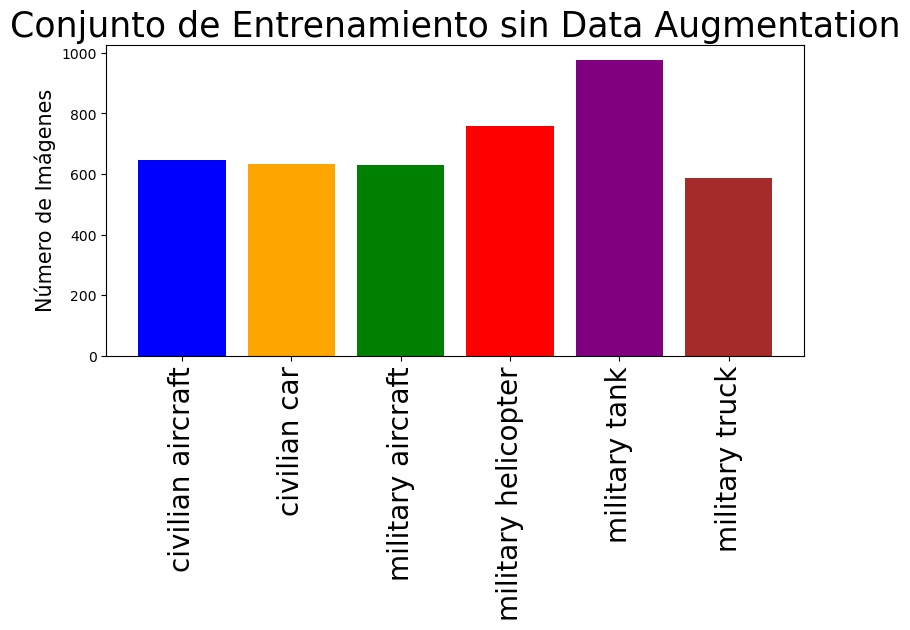

In [17]:
fig = classification_plot(class_counts_train, 
                          ARRANGED_CLASSES_CLASSIFICATION, 
                          COLORS_CLASSIFICATION,
                          "Conjunto de Entrenamiento sin Data Augmentation")
fig.savefig("plots/classification_train_noaug.png", bbox_inches="tight")

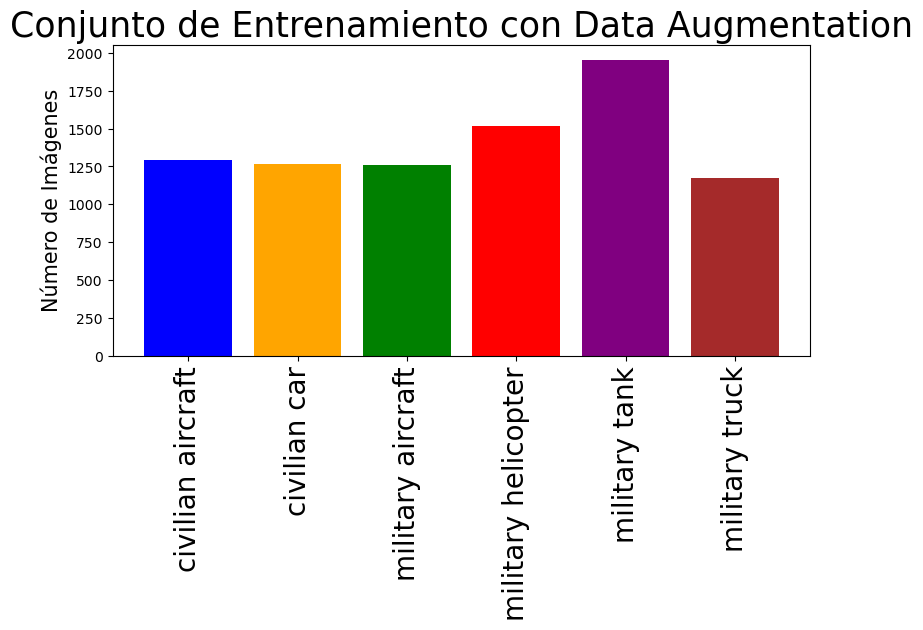

In [18]:
fig = classification_plot(class_counts_train_augmented, 
                          ARRANGED_CLASSES_CLASSIFICATION, 
                          COLORS_CLASSIFICATION,
                          "Conjunto de Entrenamiento con Data Augmentation")
fig.savefig("plots/classification_train_aug.png", bbox_inches="tight")

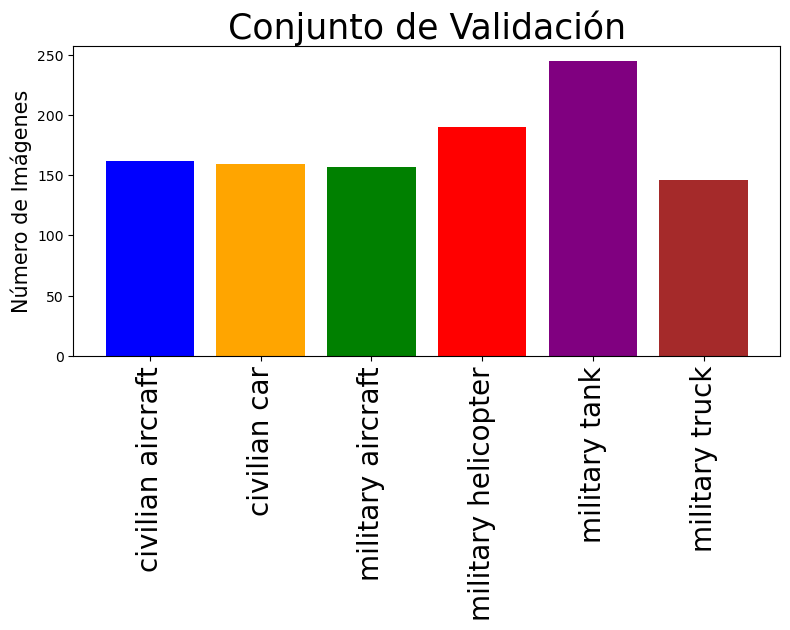

In [19]:
fig = classification_plot(class_counts_val, 
                          ARRANGED_CLASSES_CLASSIFICATION, 
                          COLORS_CLASSIFICATION,
                          "Conjunto de Validación")
fig.savefig("plots/classification_val.png", bbox_inches="tight")

## Gráficas de Detección de Objetos

Leemos la informacion de los objetos en formato tabular:

In [21]:
od_train = pd.read_feather("datasets/od_dataset_df/od_dataset_dn_train.feather")
od_val = pd.read_feather("datasets/od_dataset_df/od_dataset_dn_val.feather")
od_test = pd.read_feather("datasets/od_dataset_df/od_dataset_dn_test.feather")

Cambiamos las etiquetas por los nombres de las clases:

In [22]:
od_train.replace({"class": OD_CLASS_DICT}, inplace=True)
od_val.replace({"class": OD_CLASS_DICT}, inplace=True)
od_test.replace({"class": OD_CLASS_DICT}, inplace=True)

Representamos las gráficas:

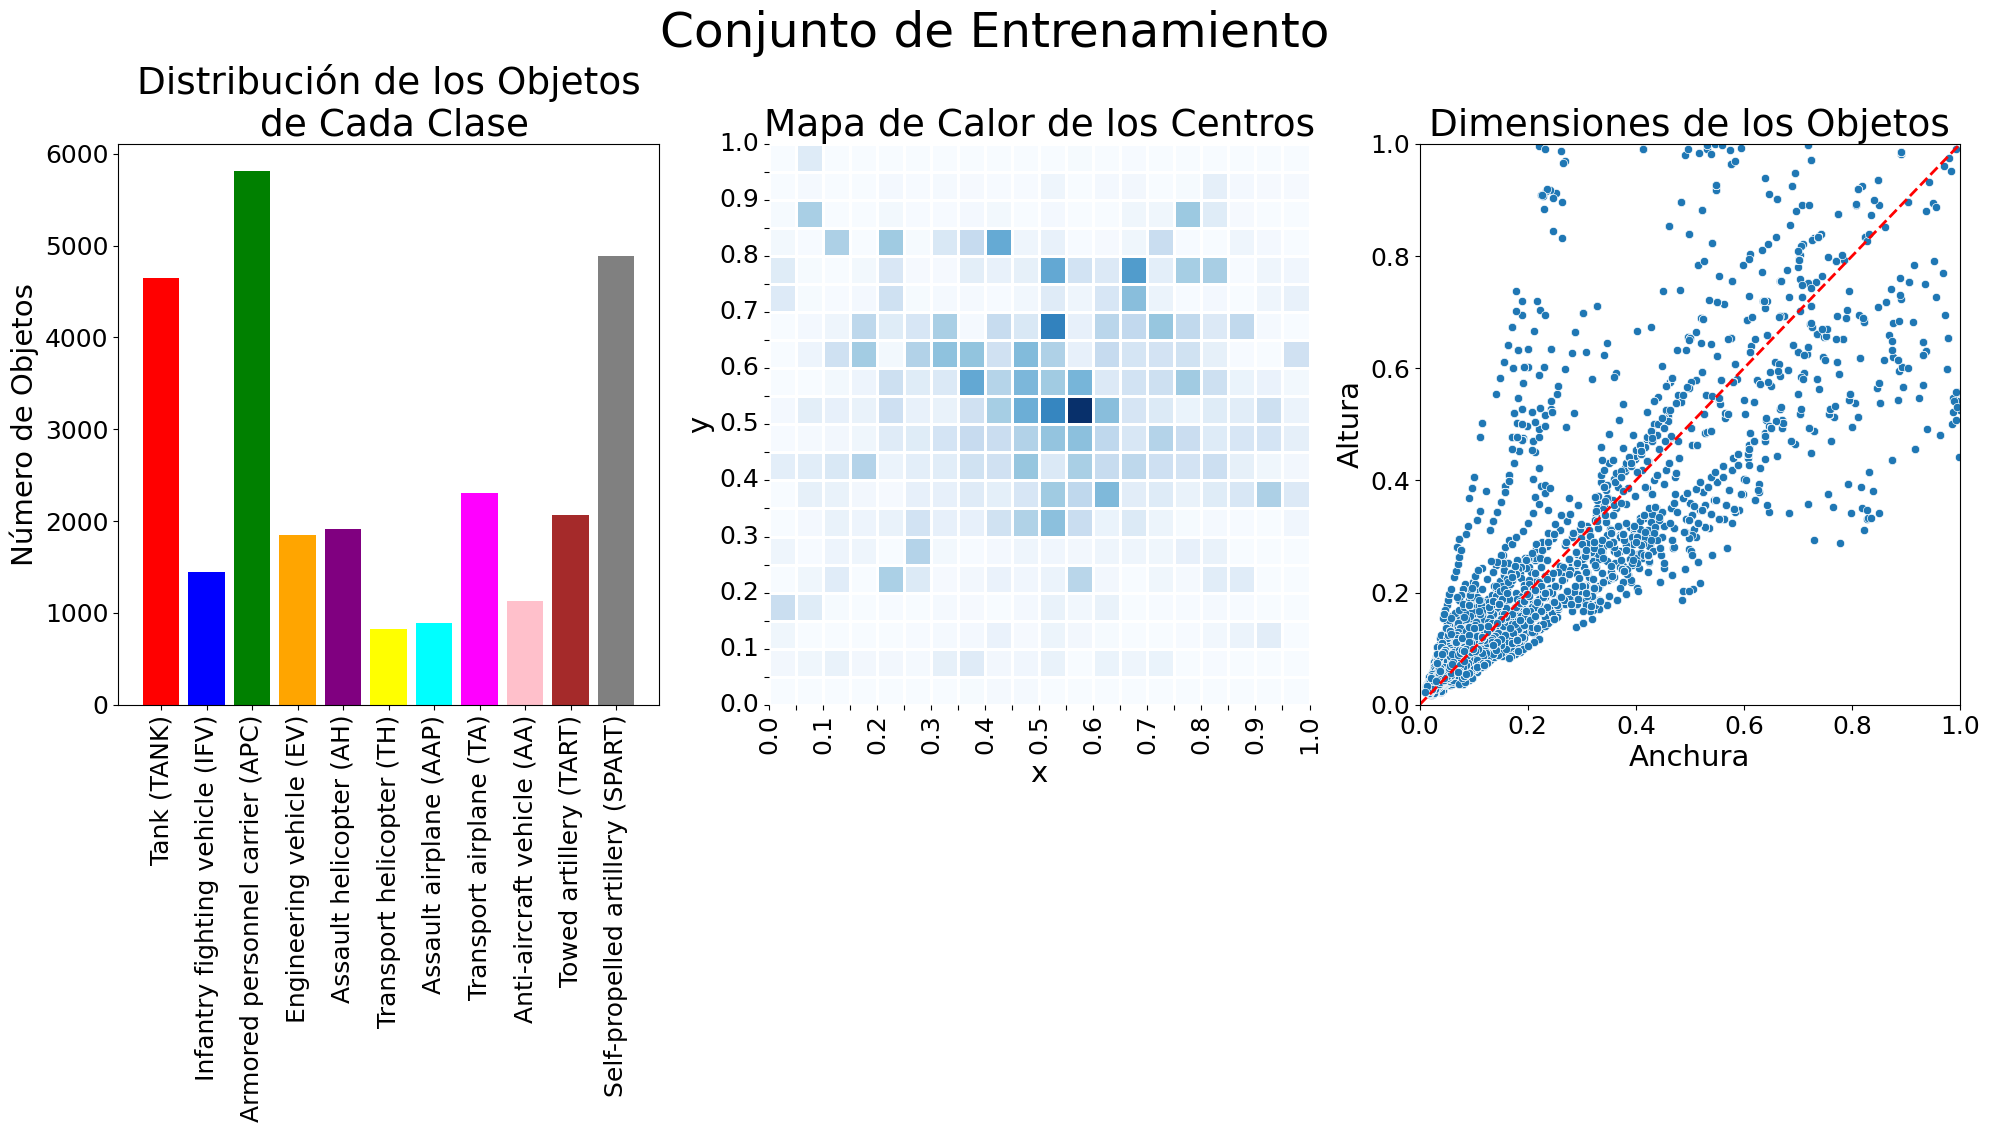

In [23]:
fig = od_plot(od_train, OD_CLASSES, OD_COLORS, "Conjunto de Entrenamiento")
fig.savefig("plots/od_train.png", bbox_inches="tight")

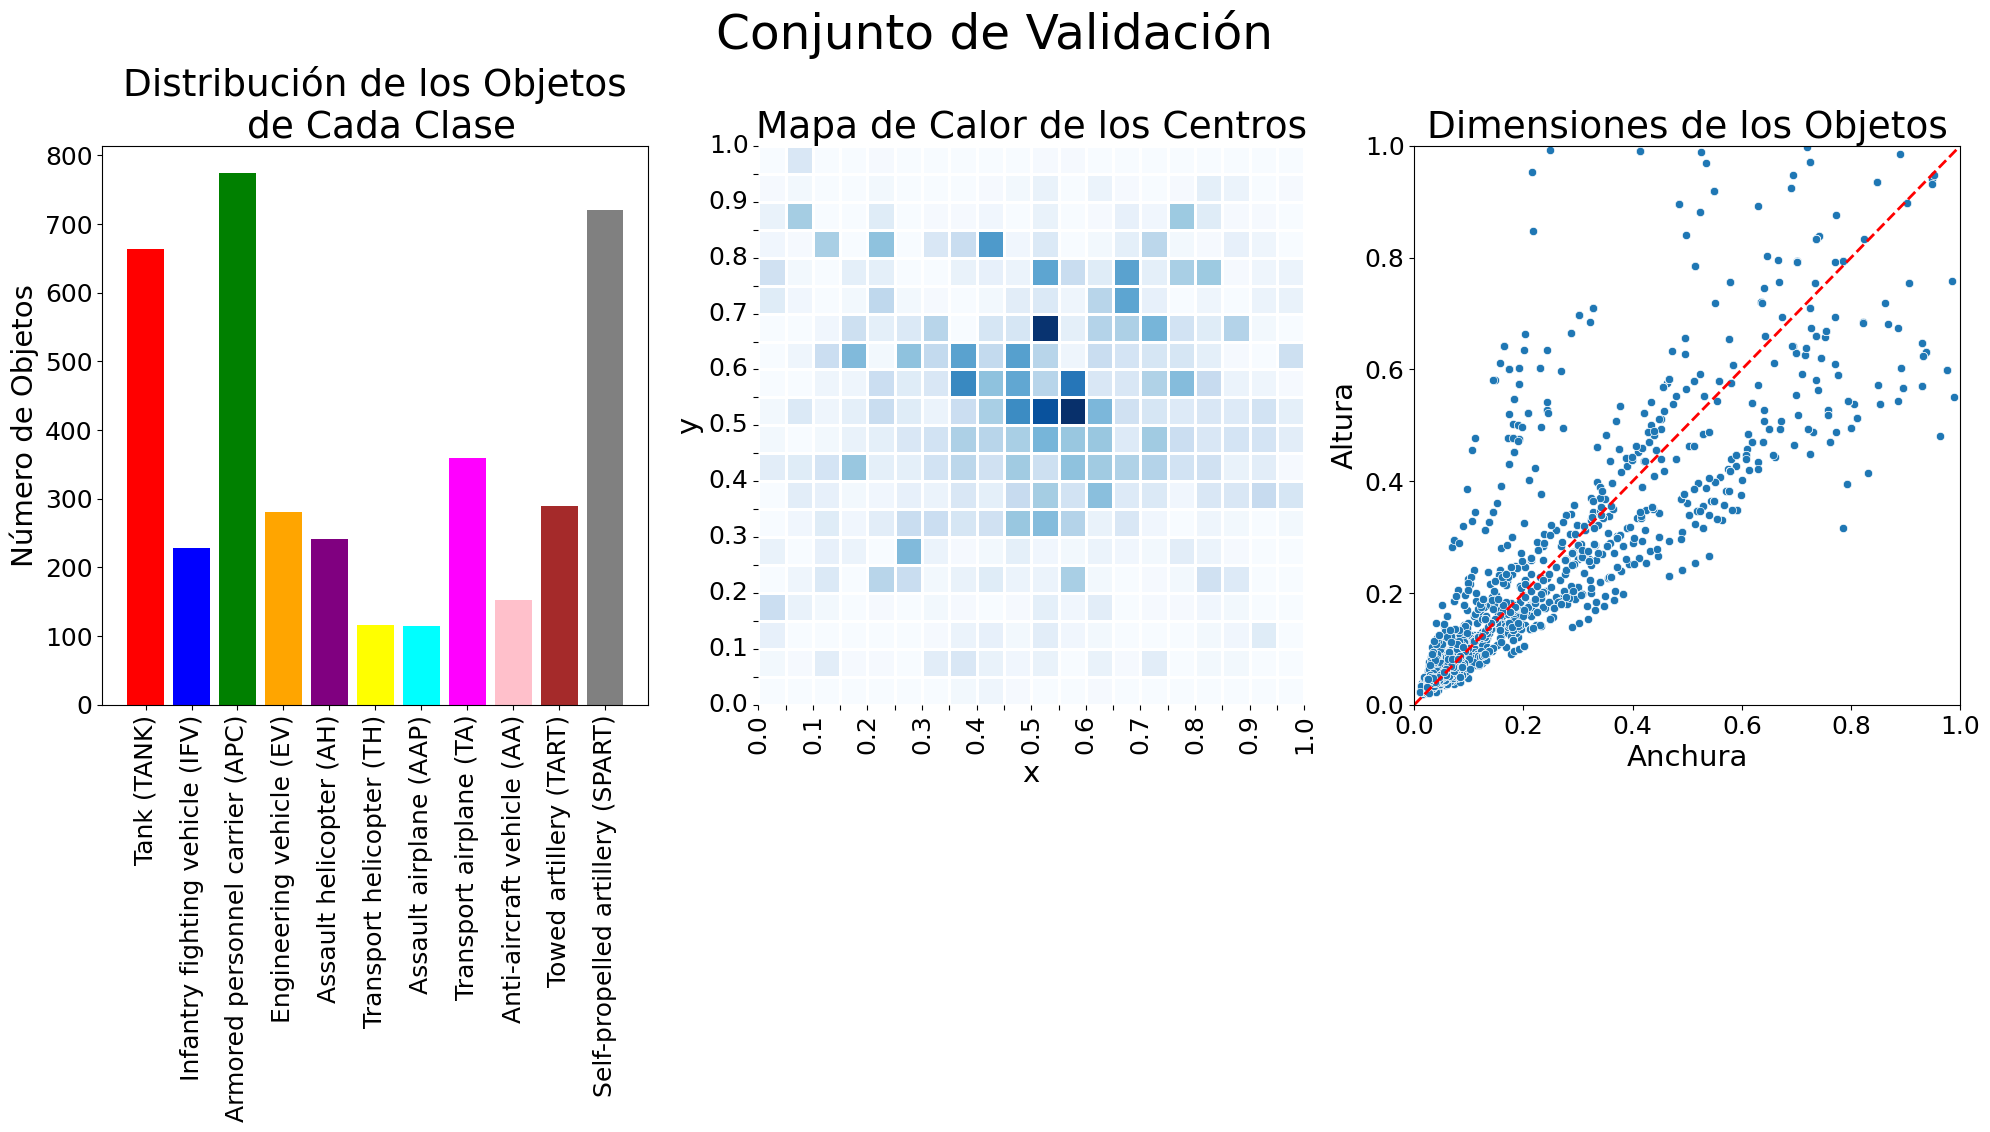

In [24]:
fig = od_plot(od_val, OD_CLASSES, OD_COLORS, "Conjunto de Validación")
fig.savefig("plots/od_val.png", bbox_inches="tight")

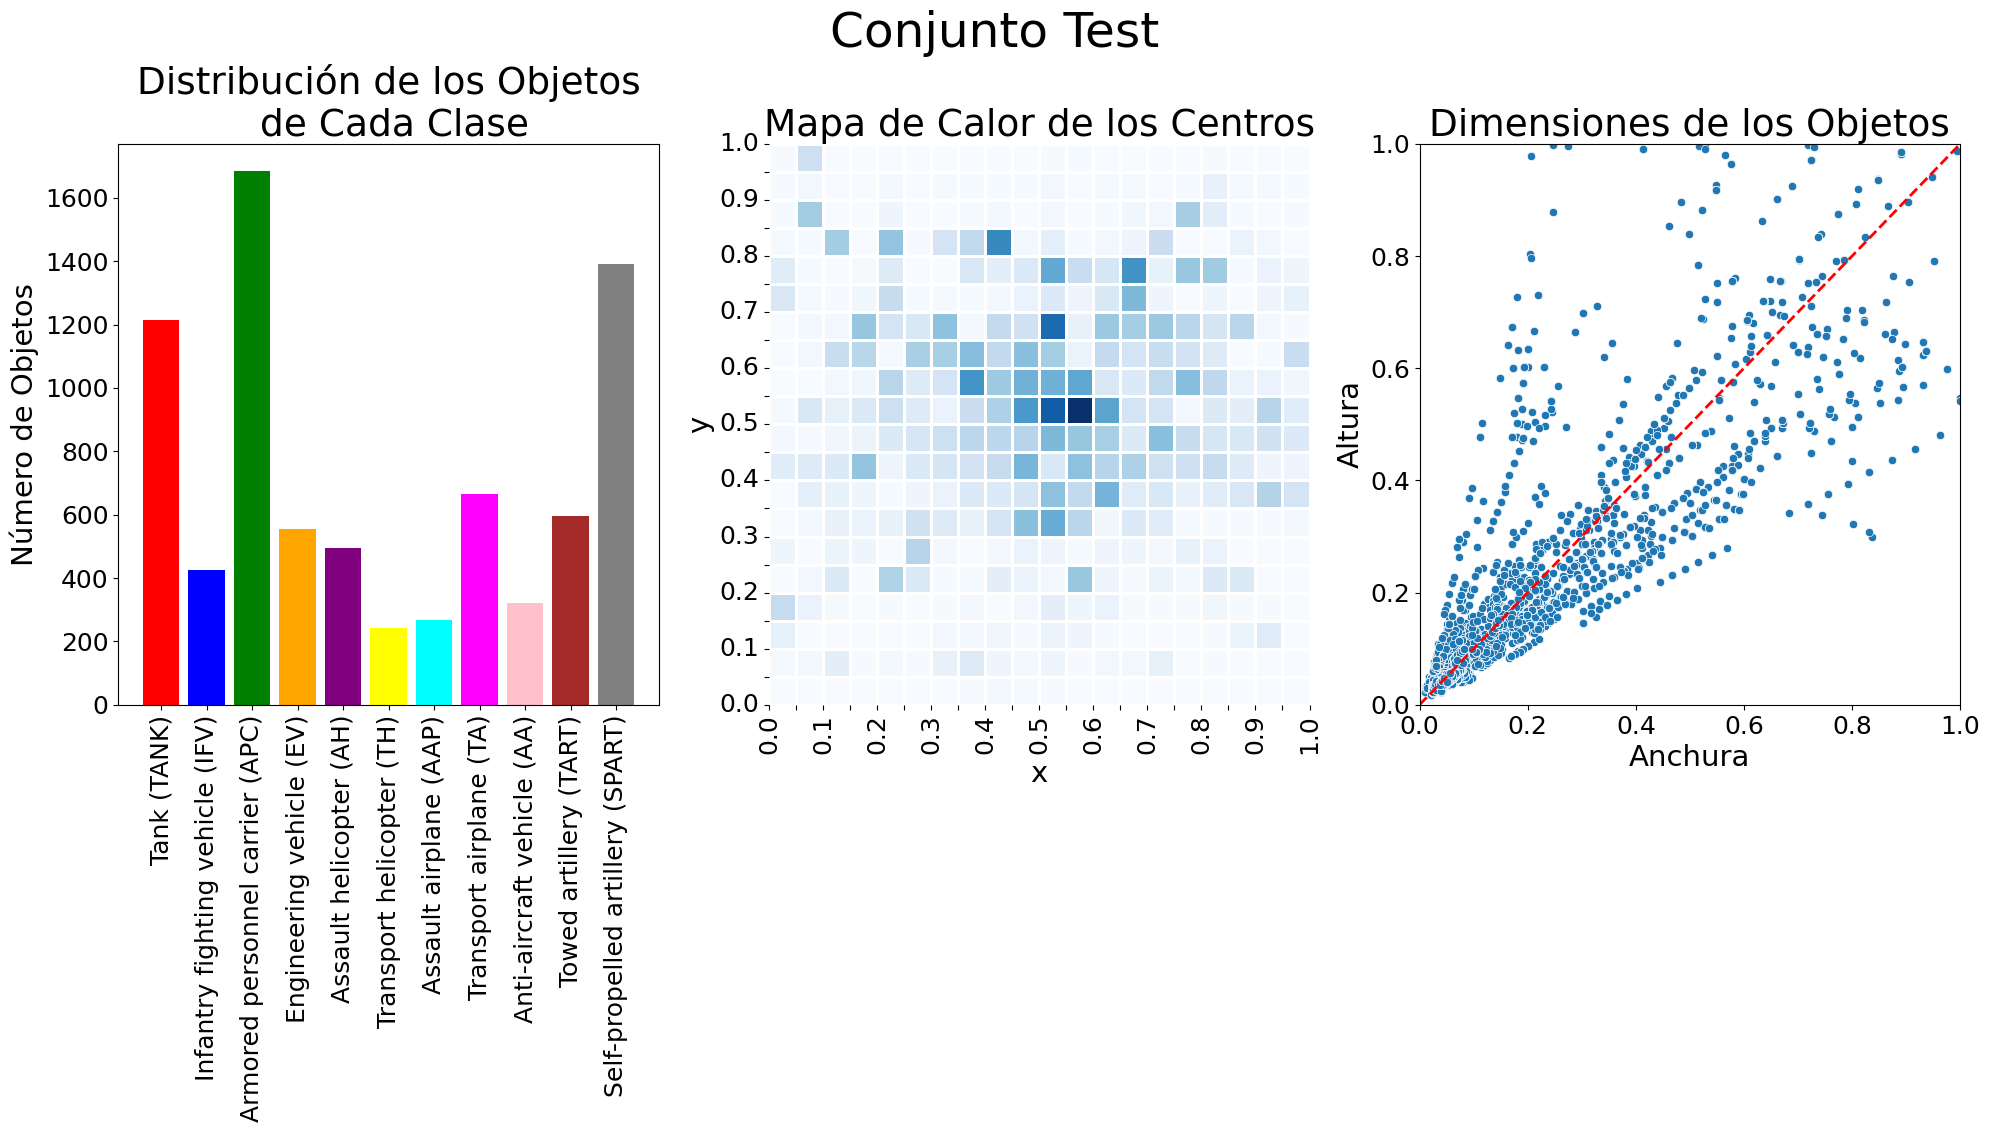

In [25]:
fig = od_plot(od_test, OD_CLASSES, OD_COLORS, "Conjunto Test")
fig.savefig("plots/od_test.png", bbox_inches="tight")

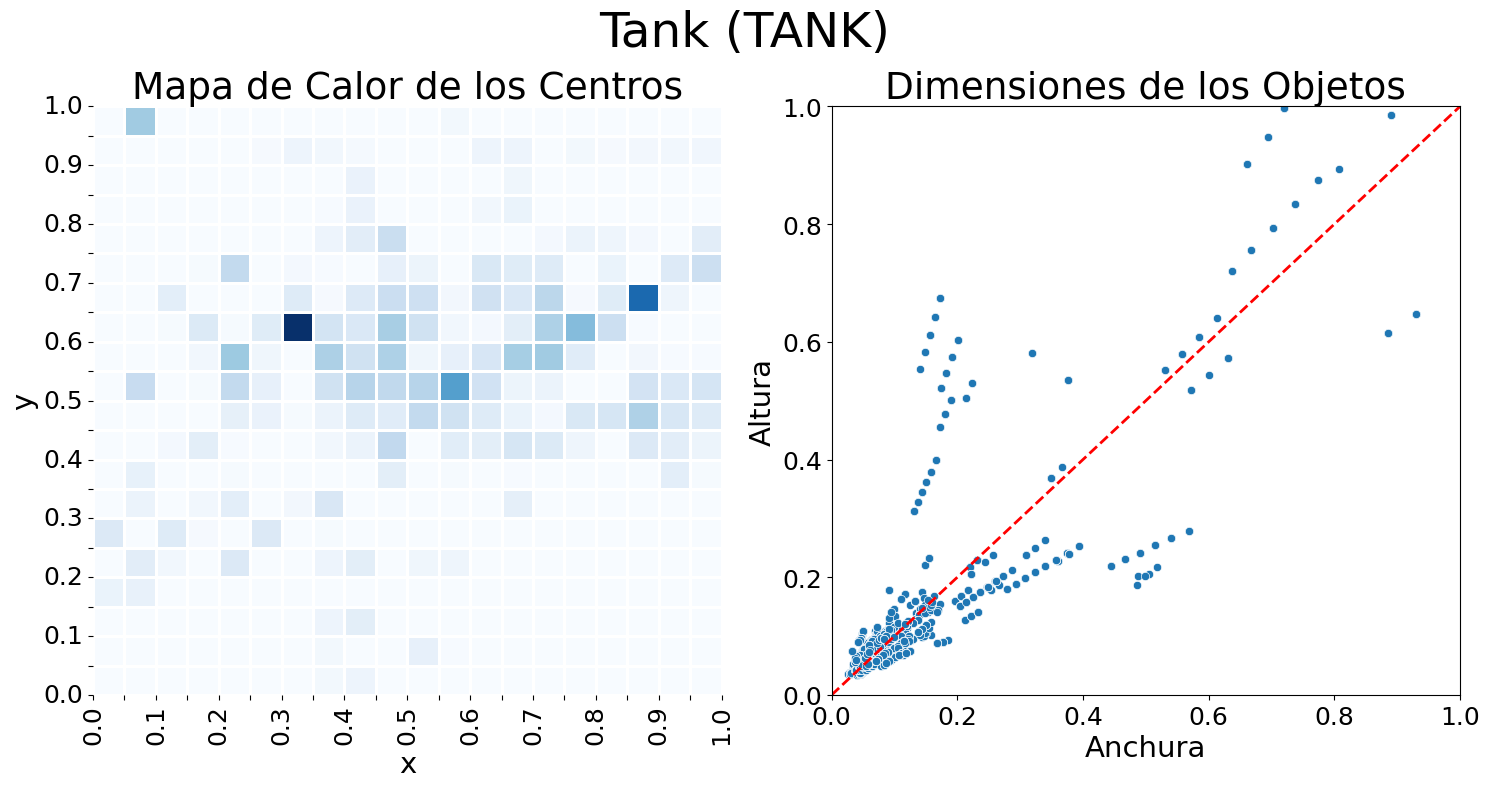

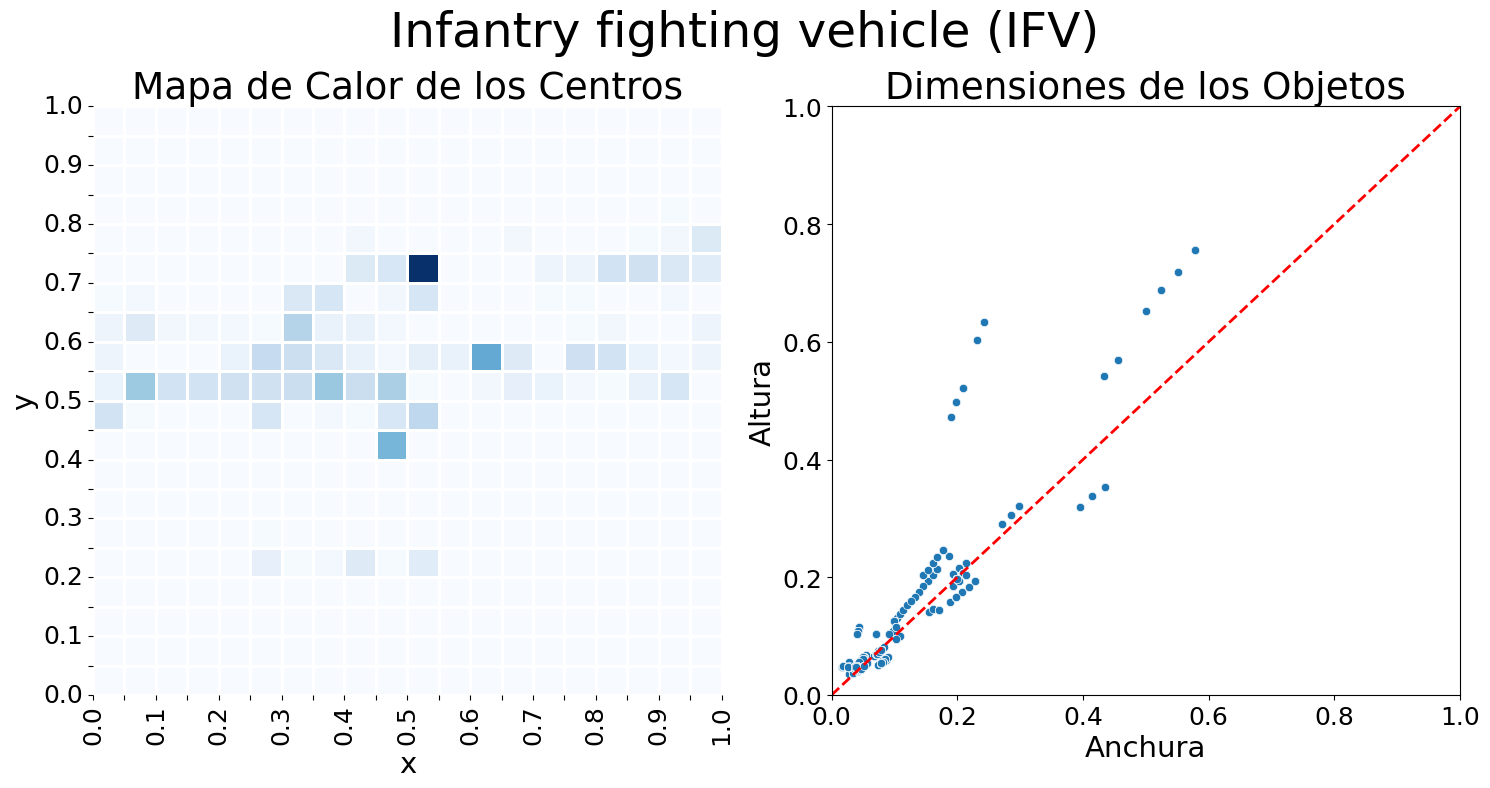

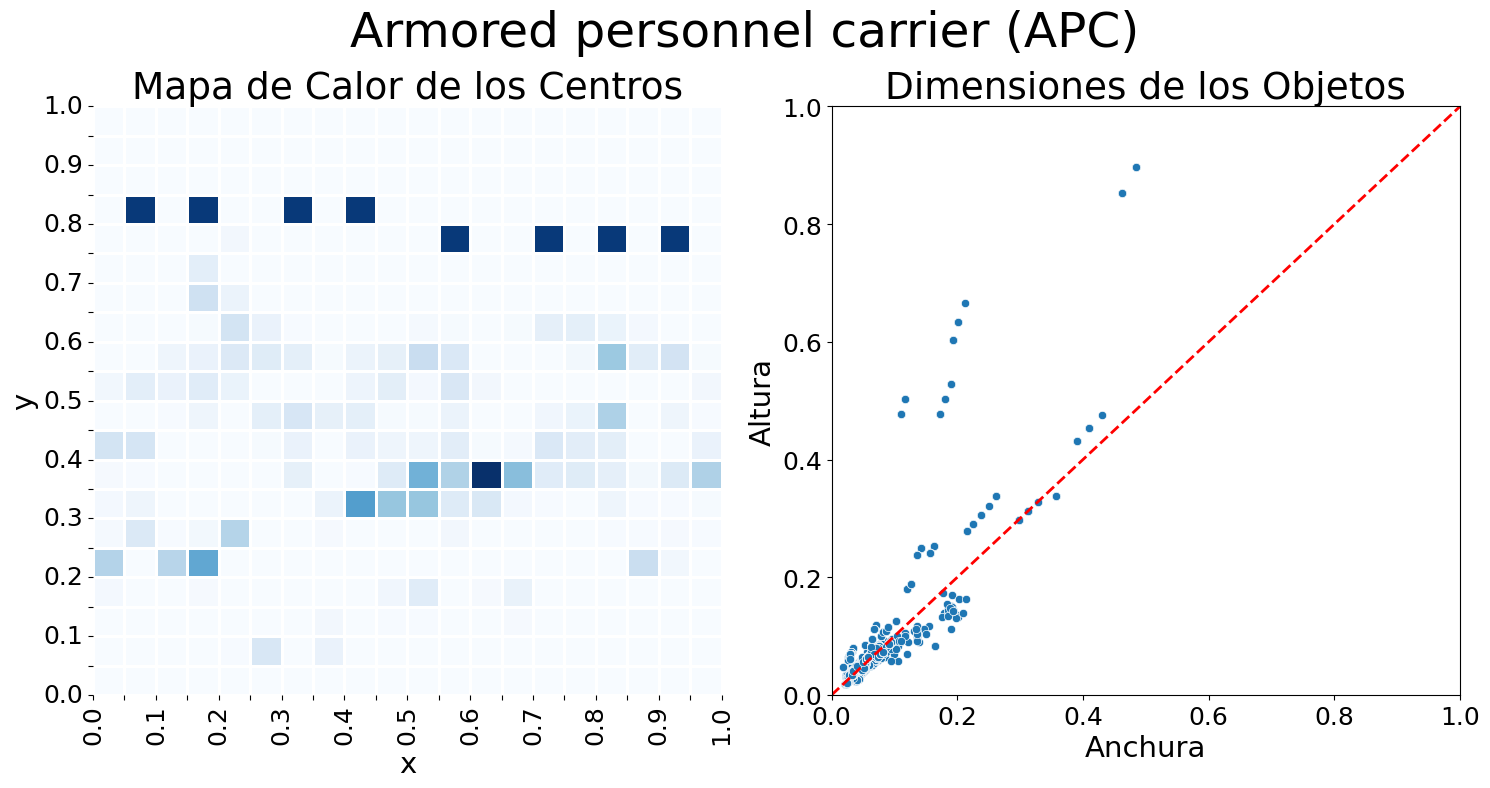

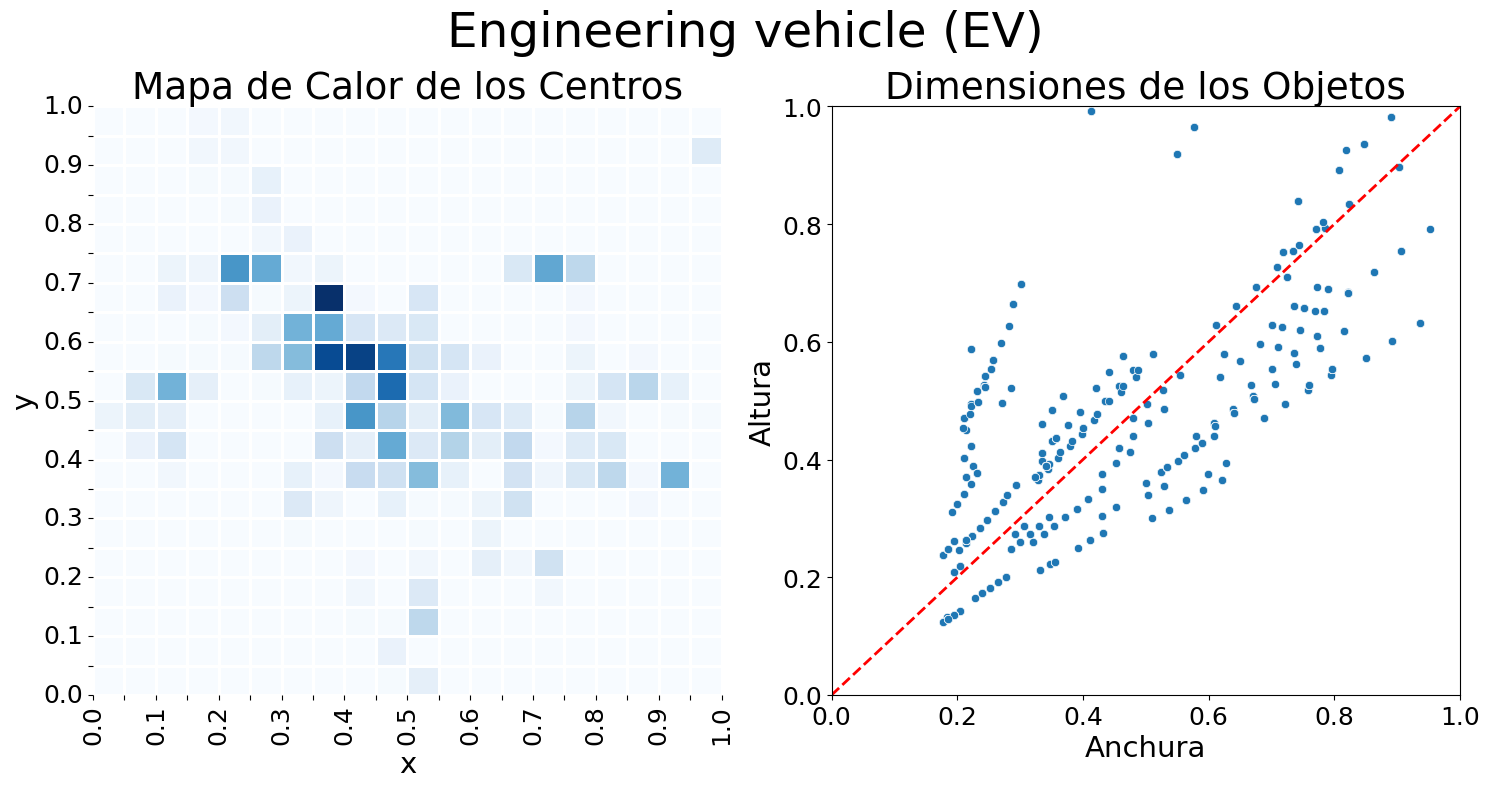

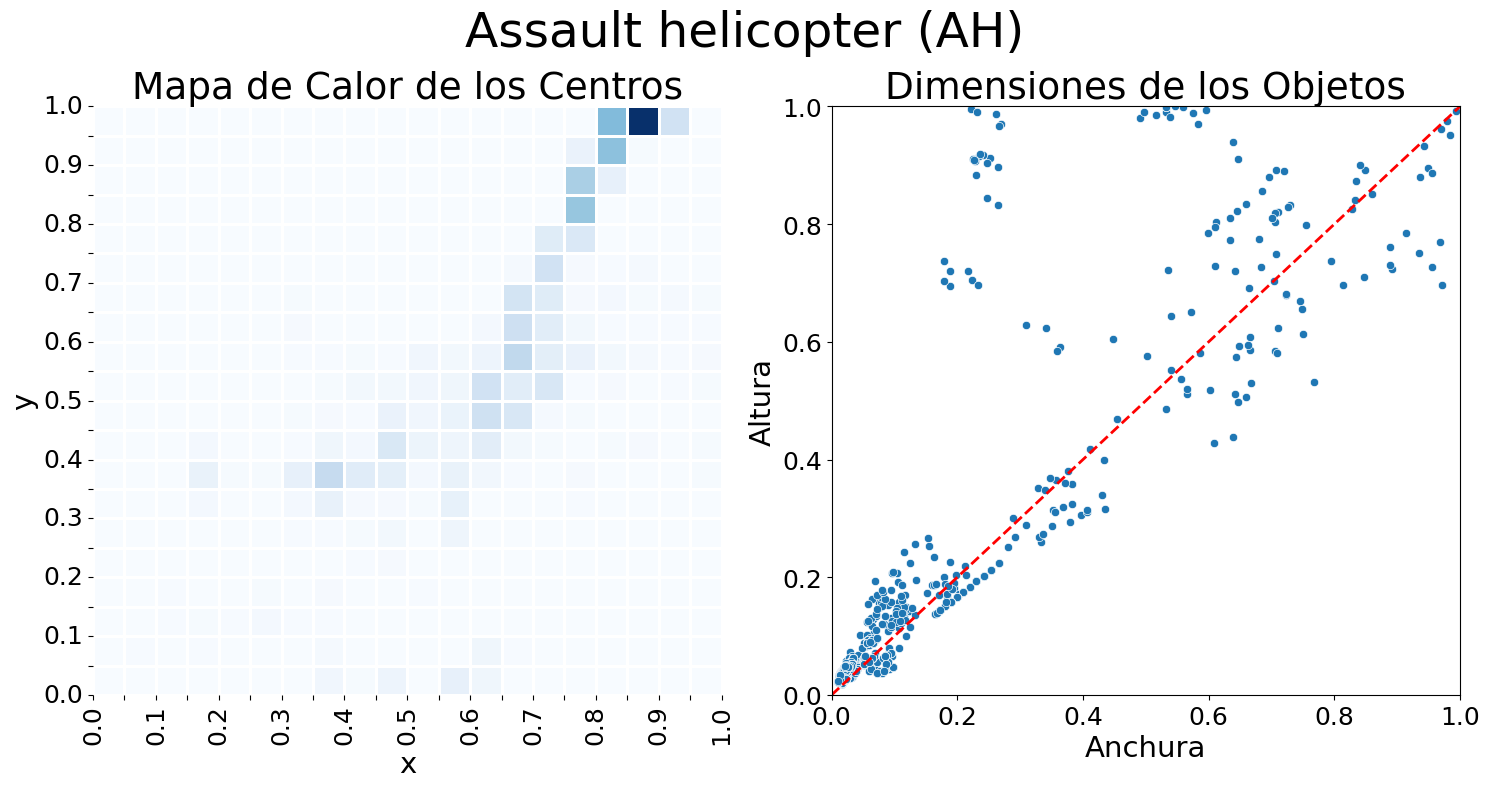

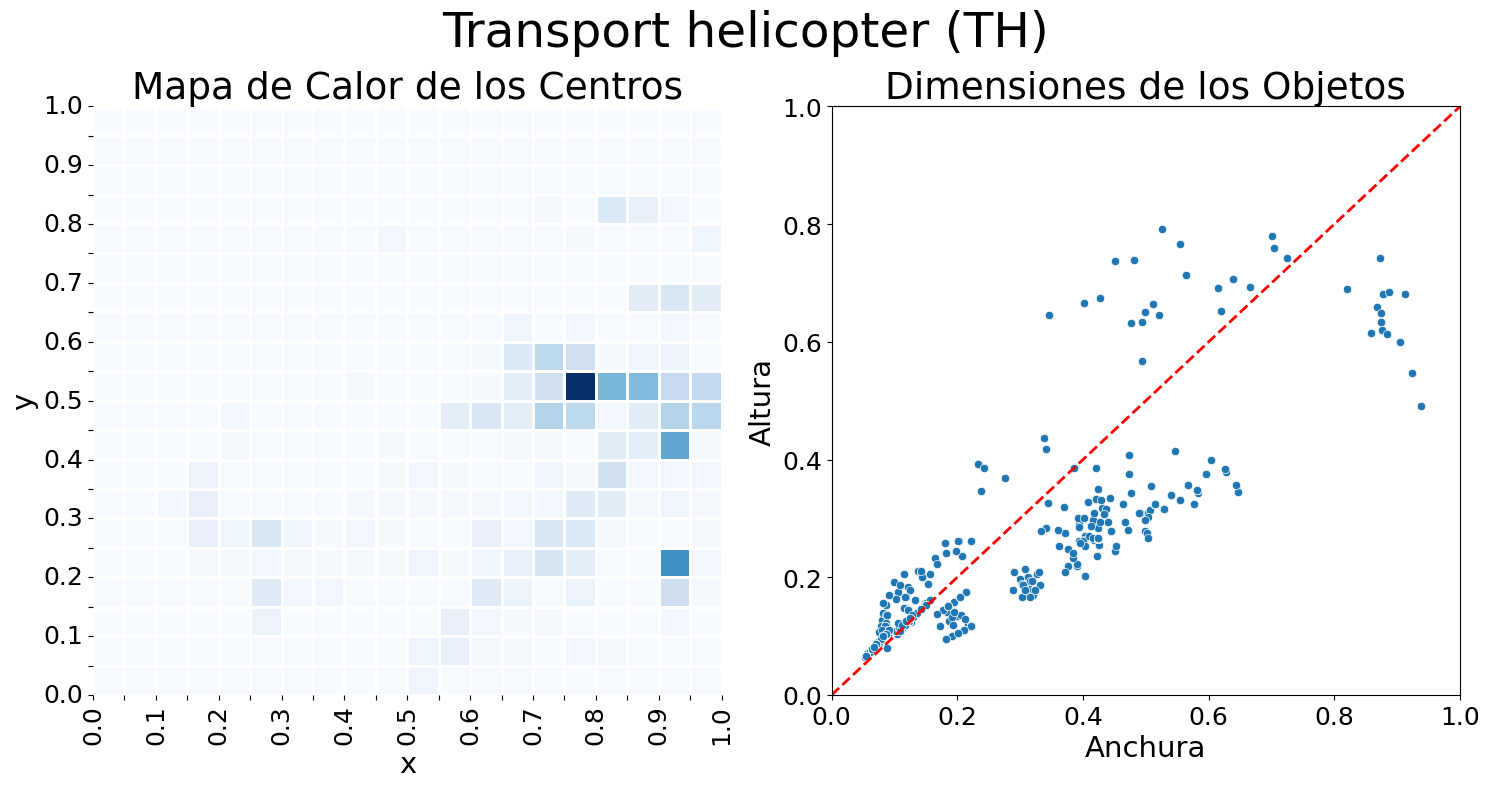

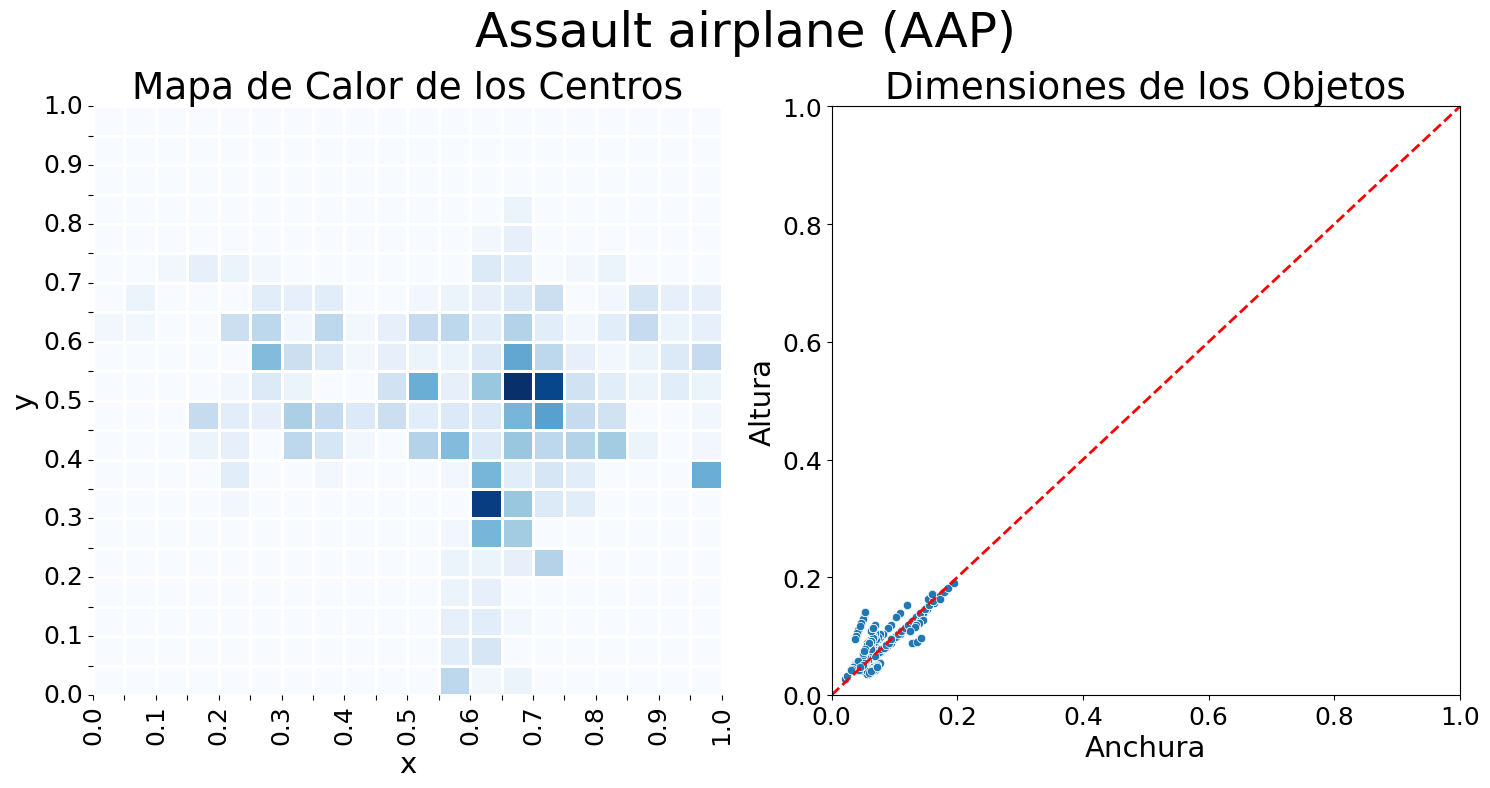

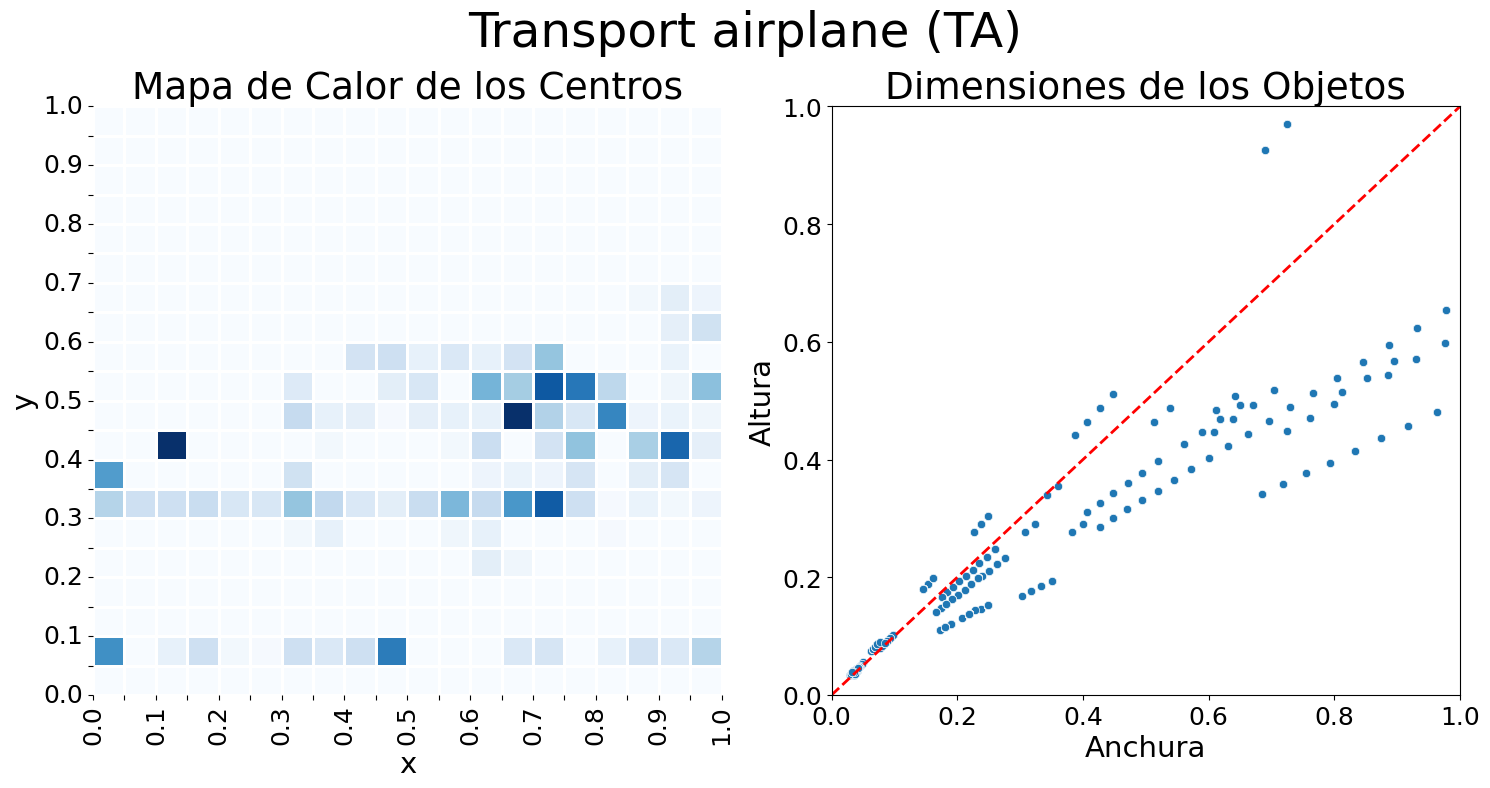

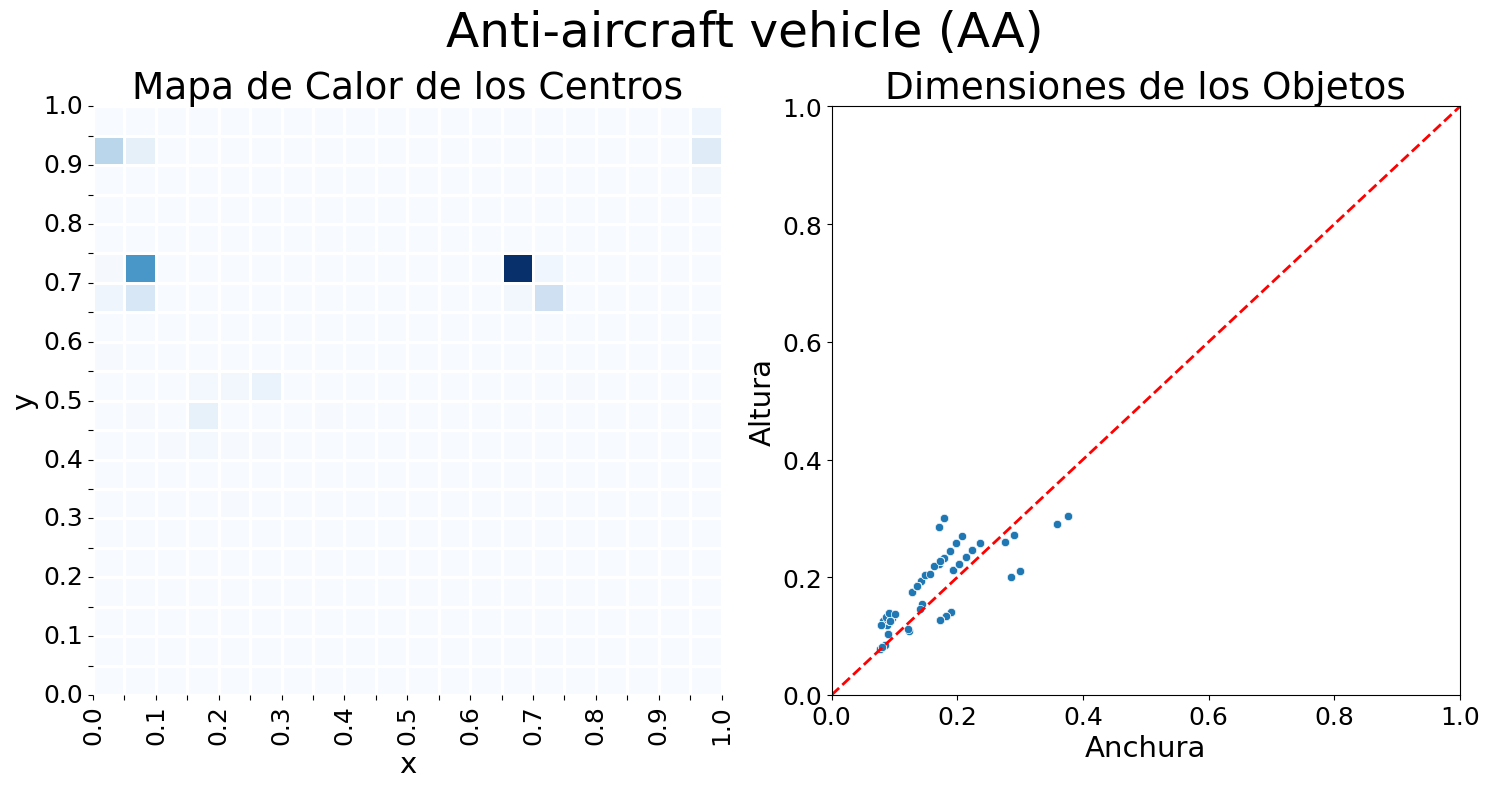

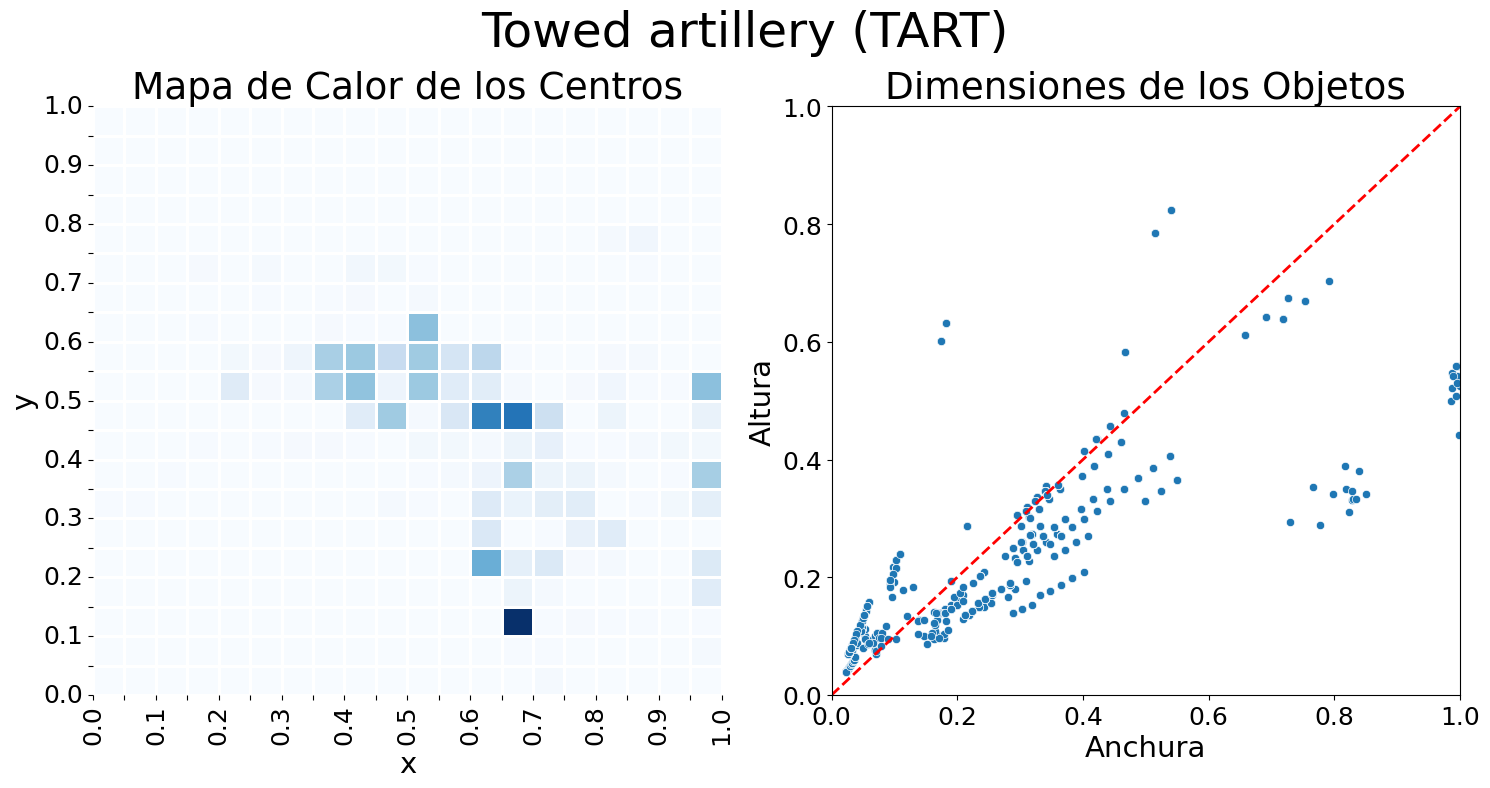

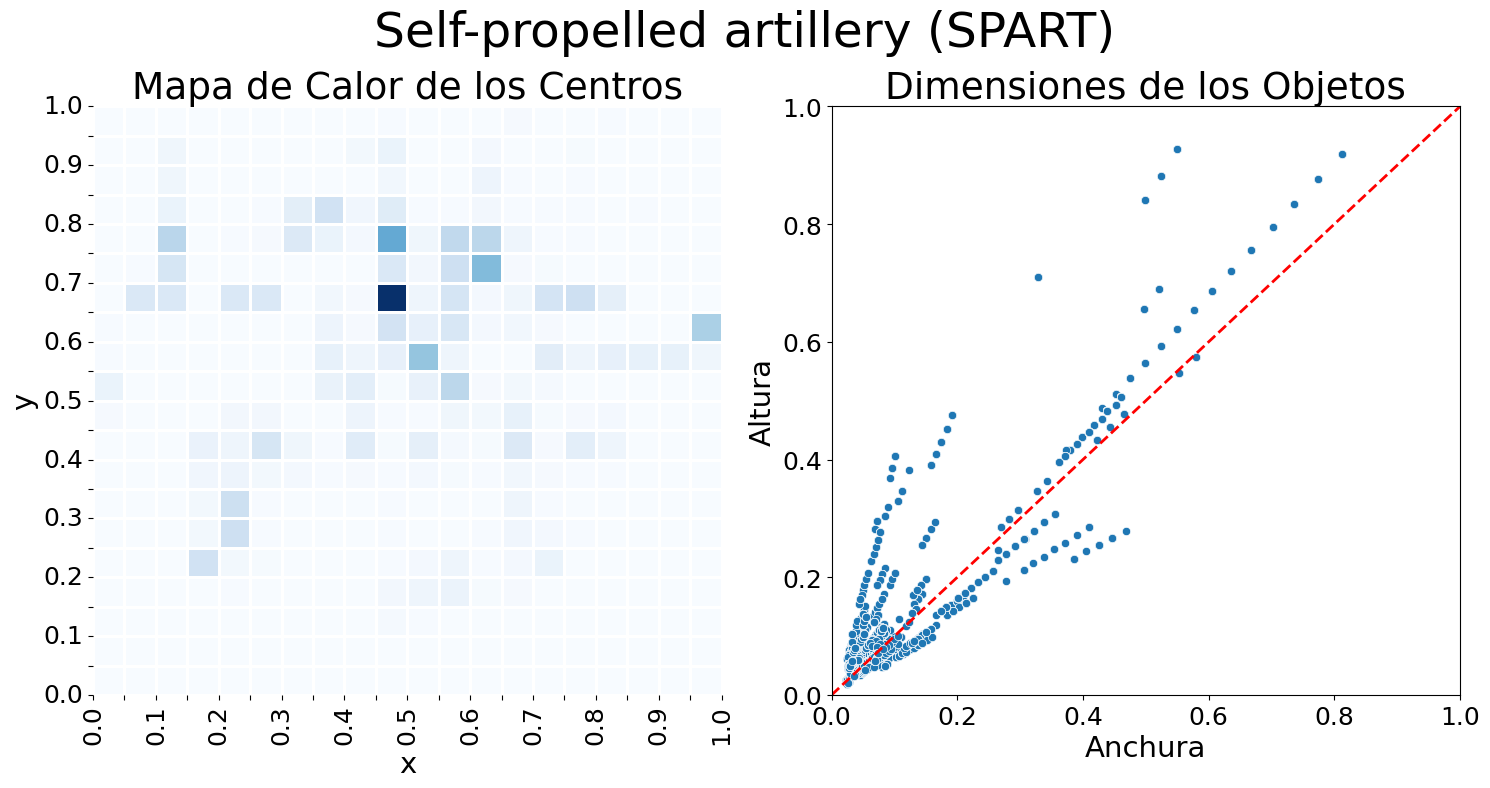

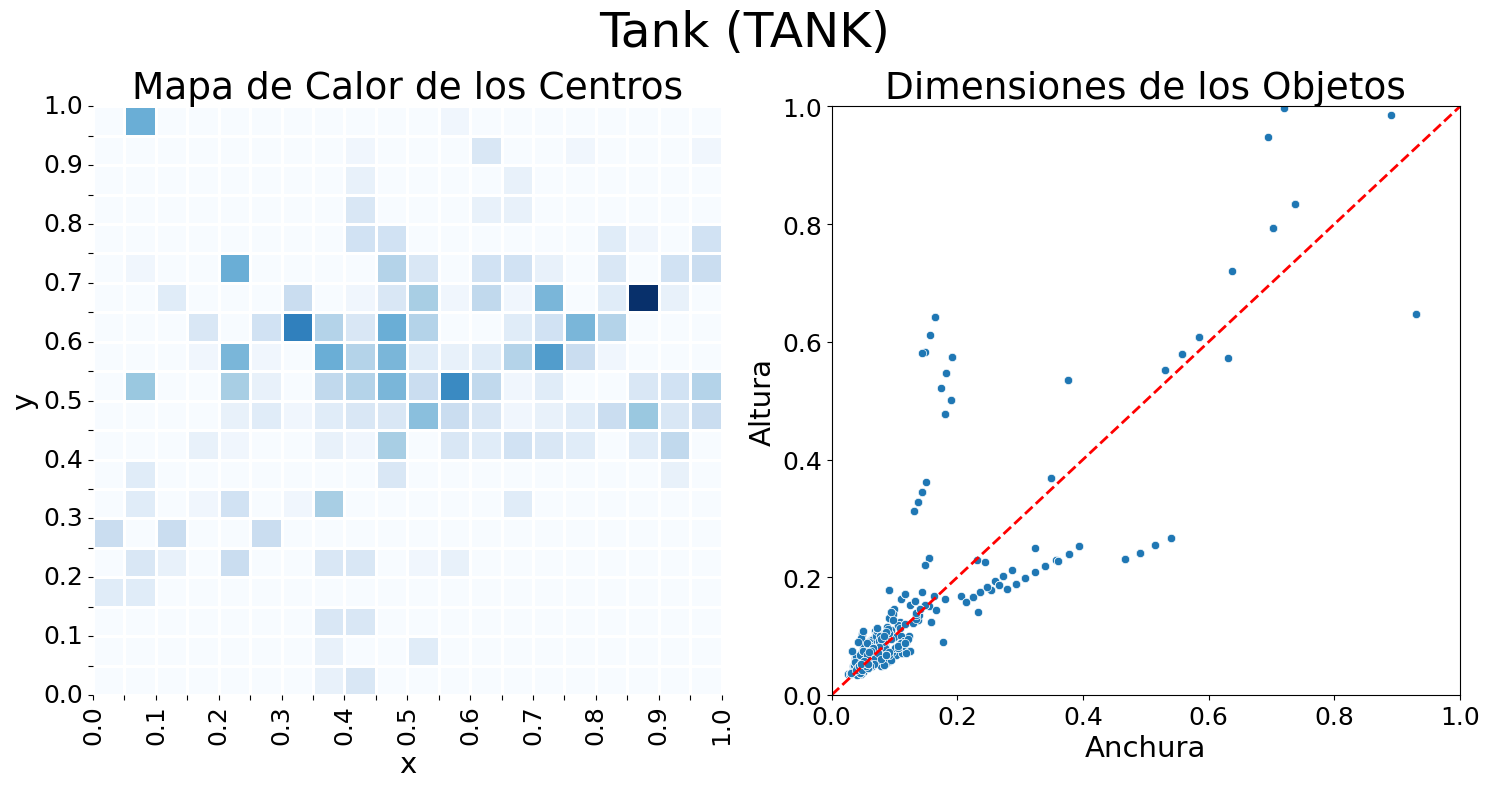

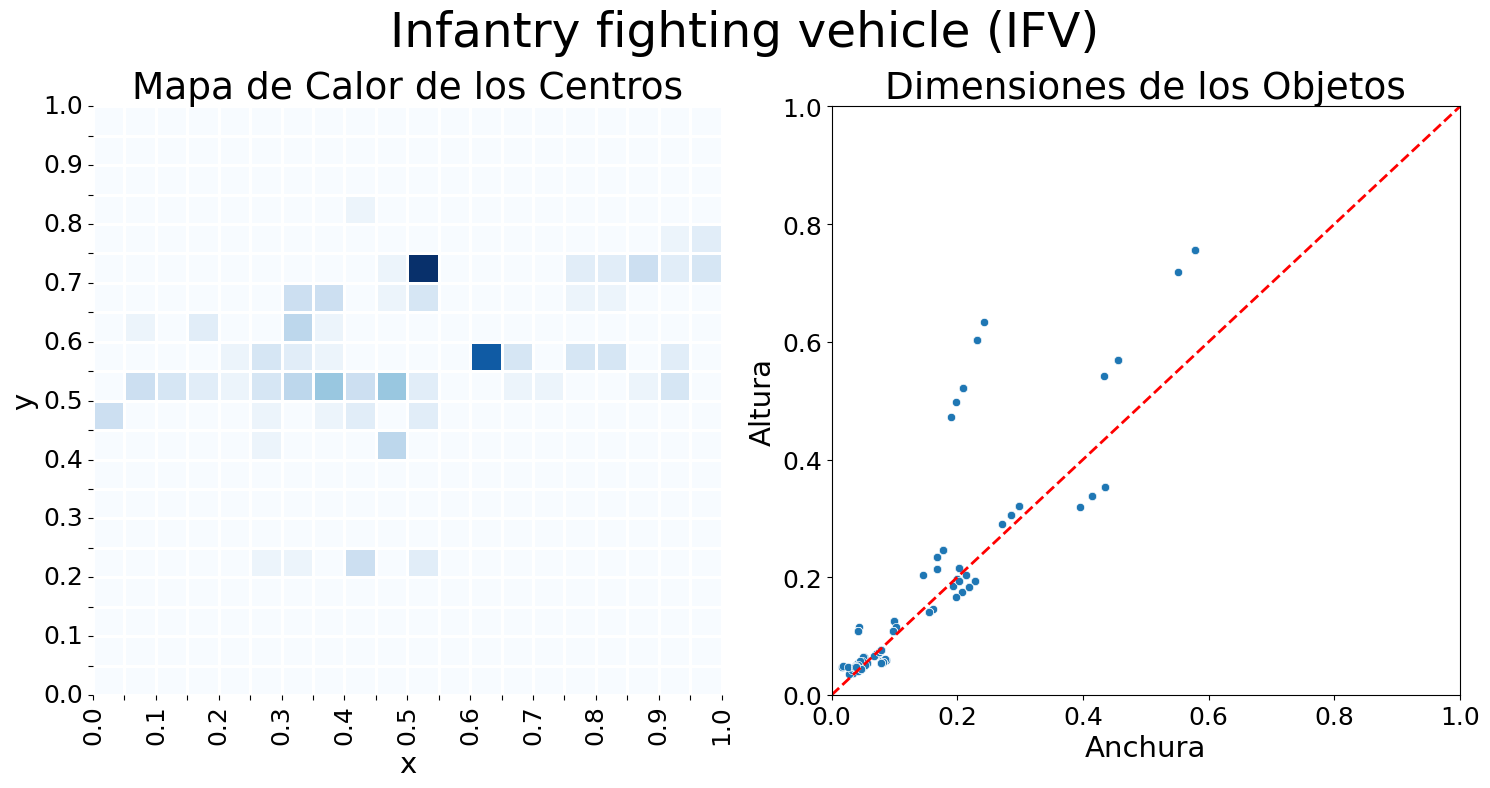

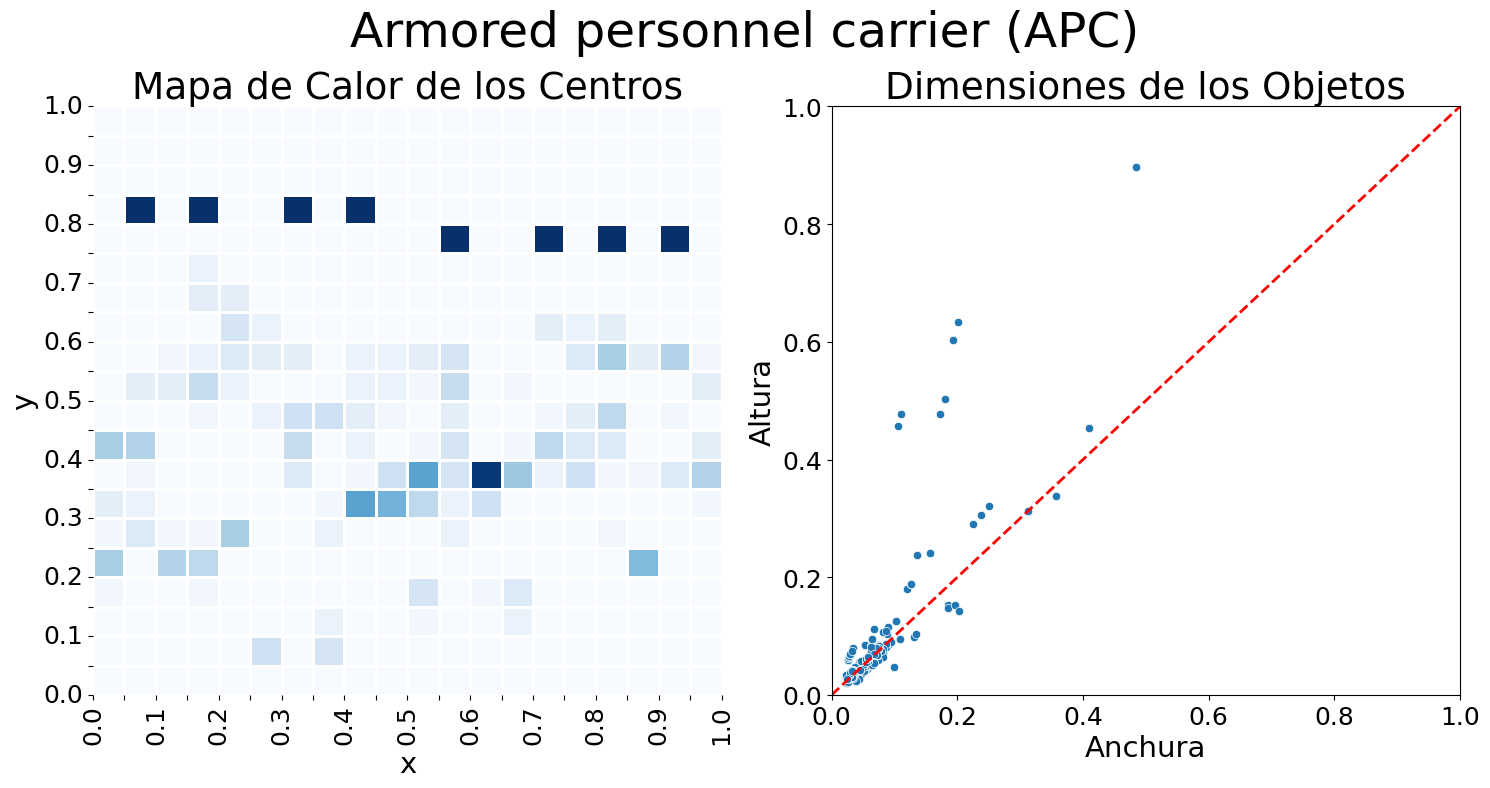

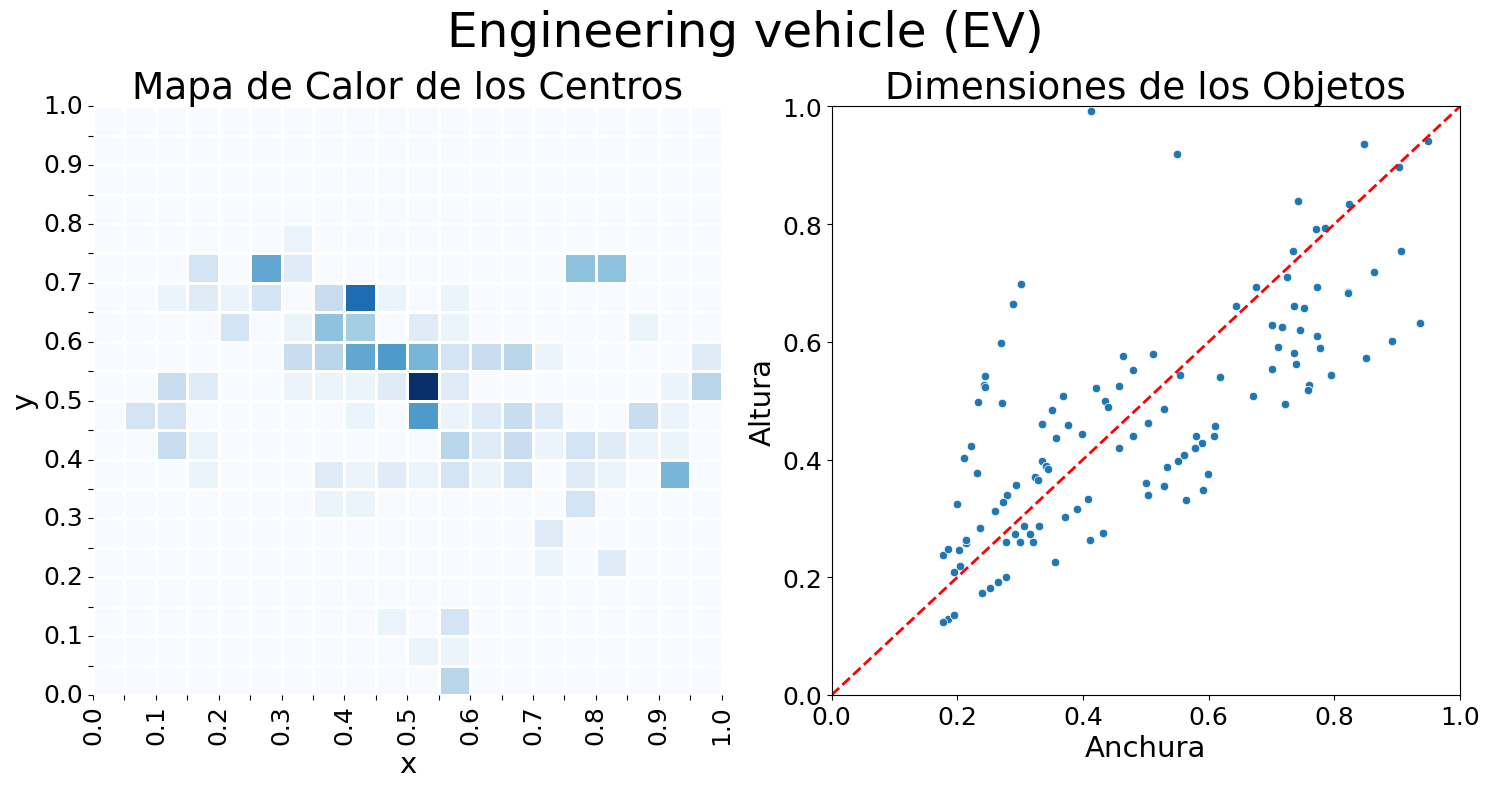

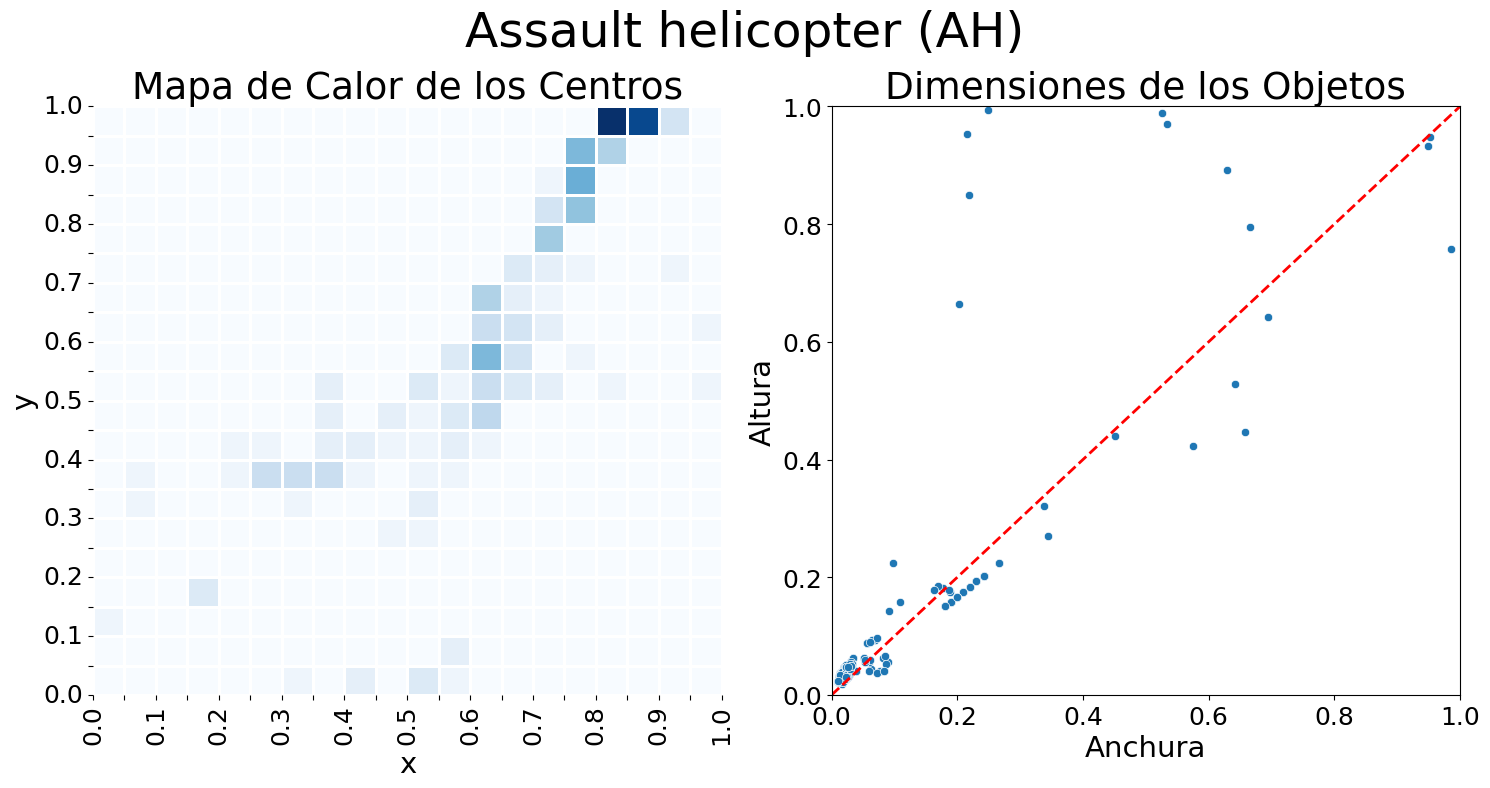

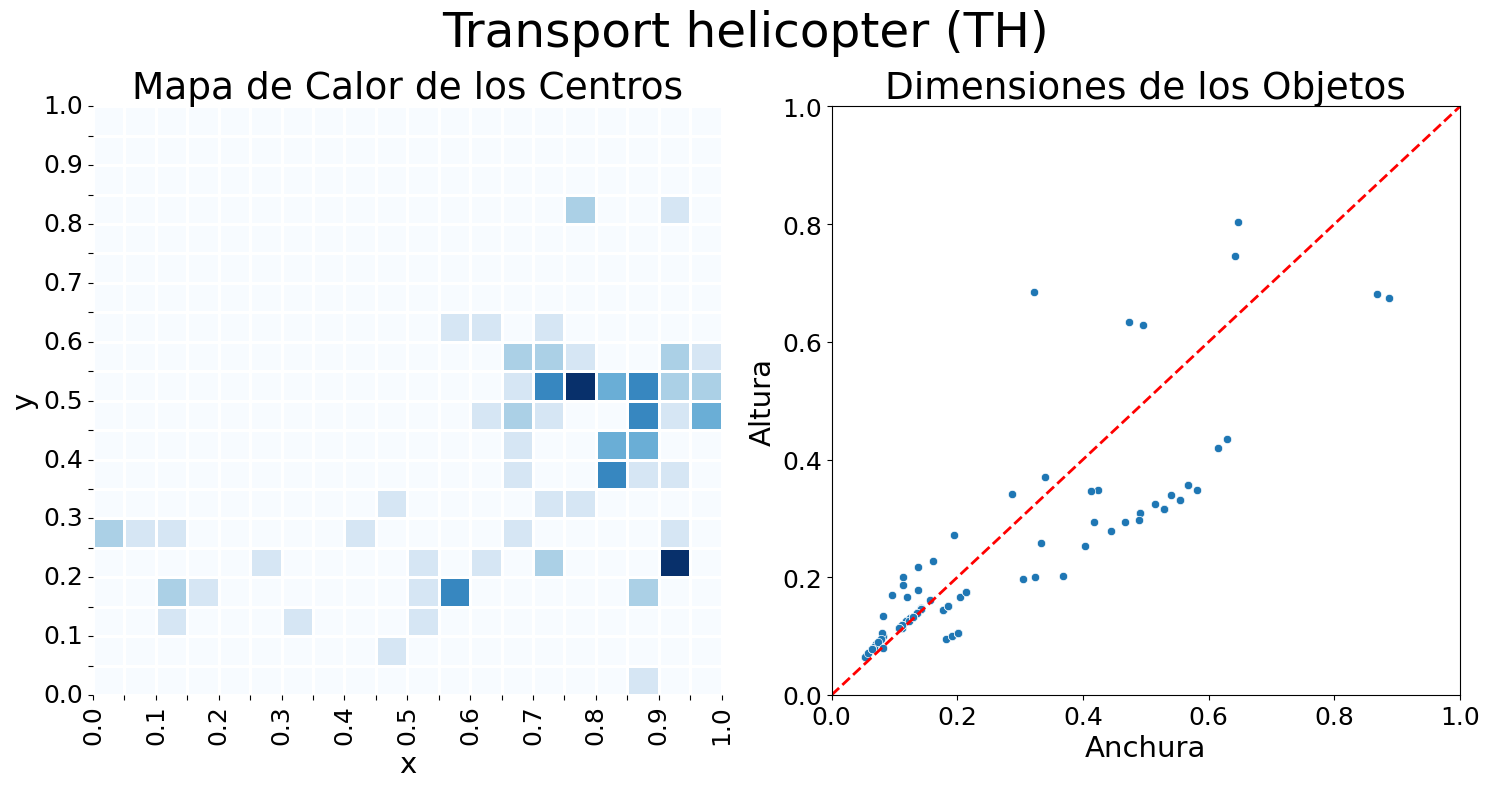

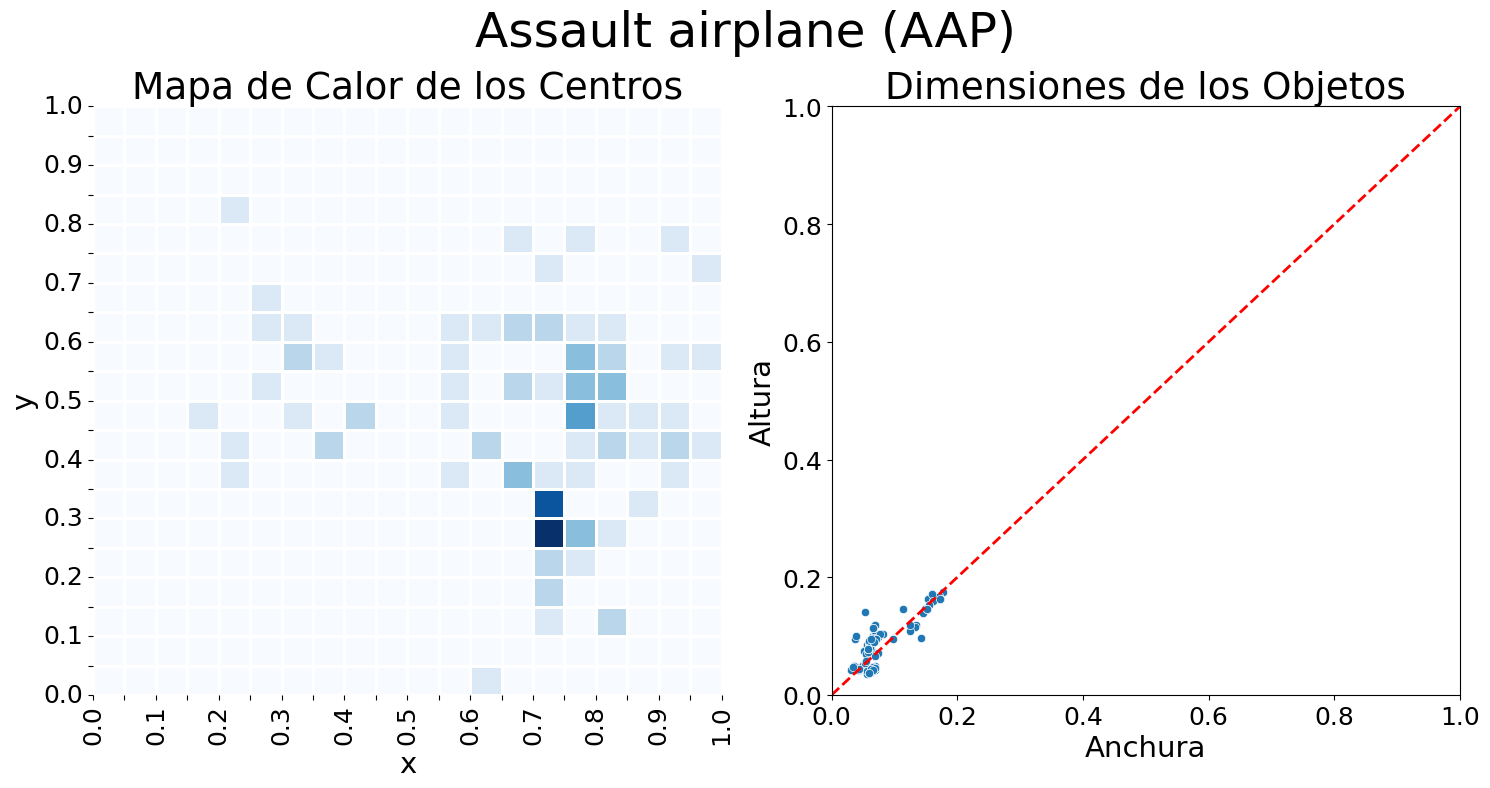

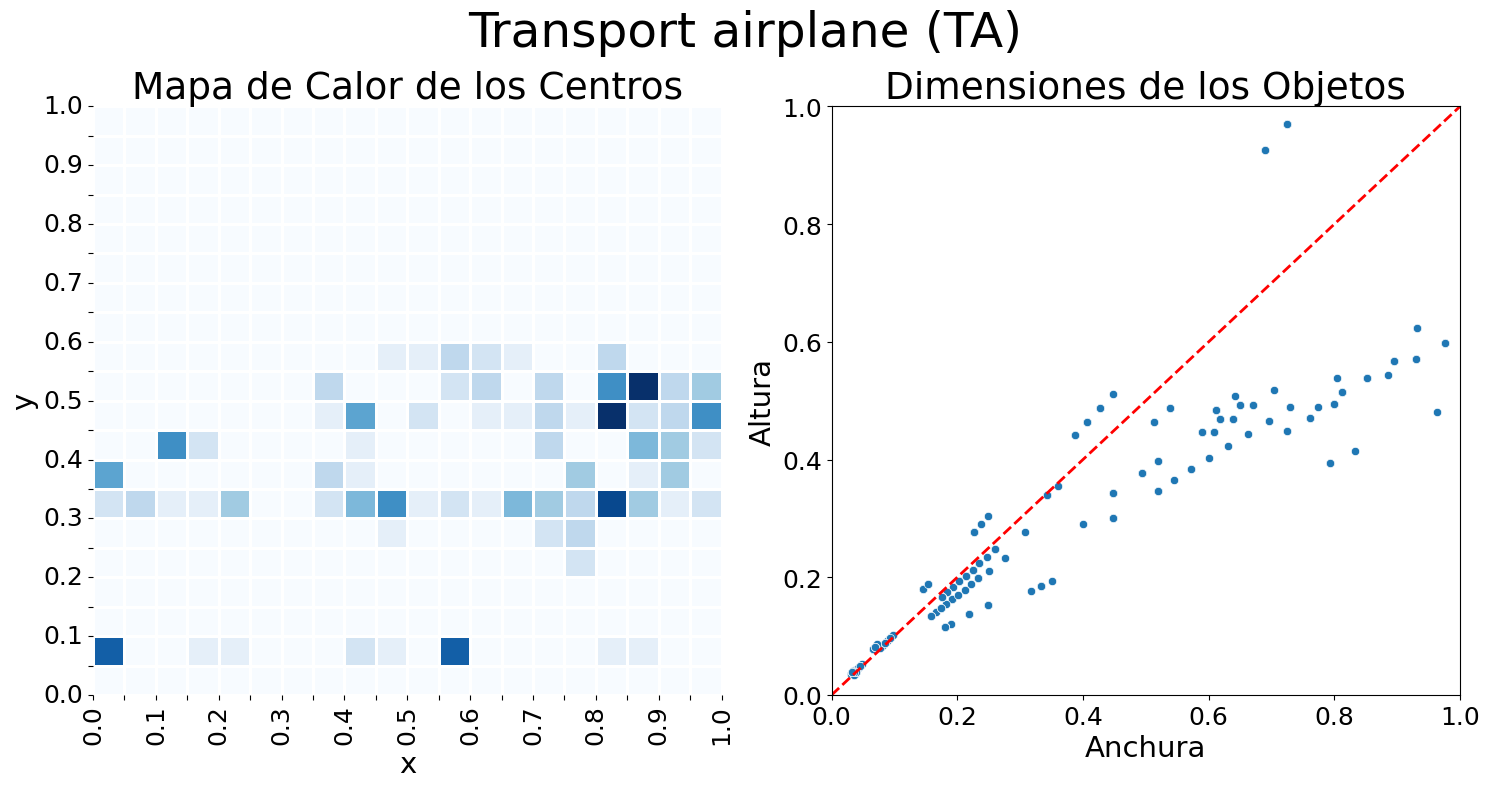

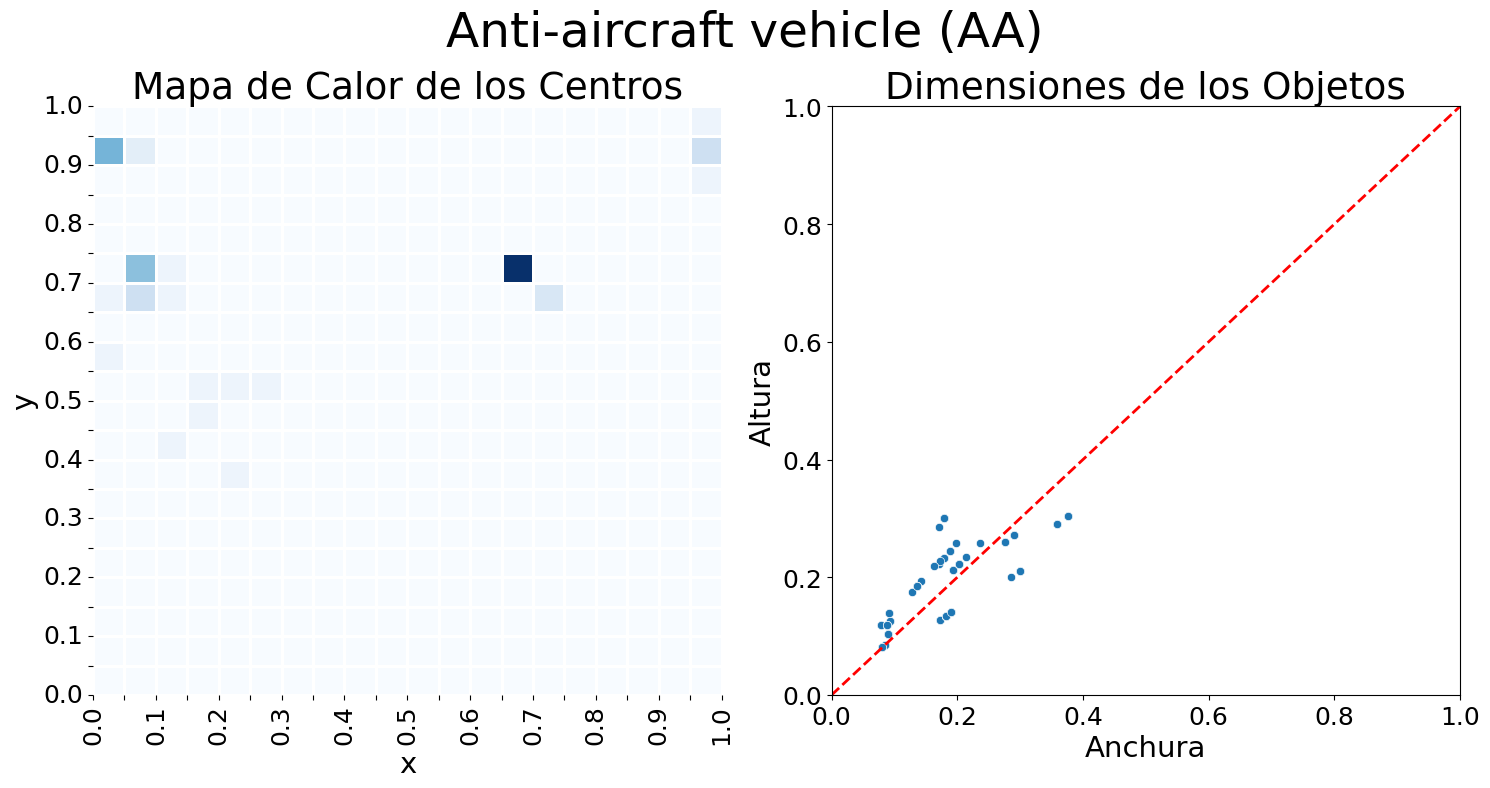

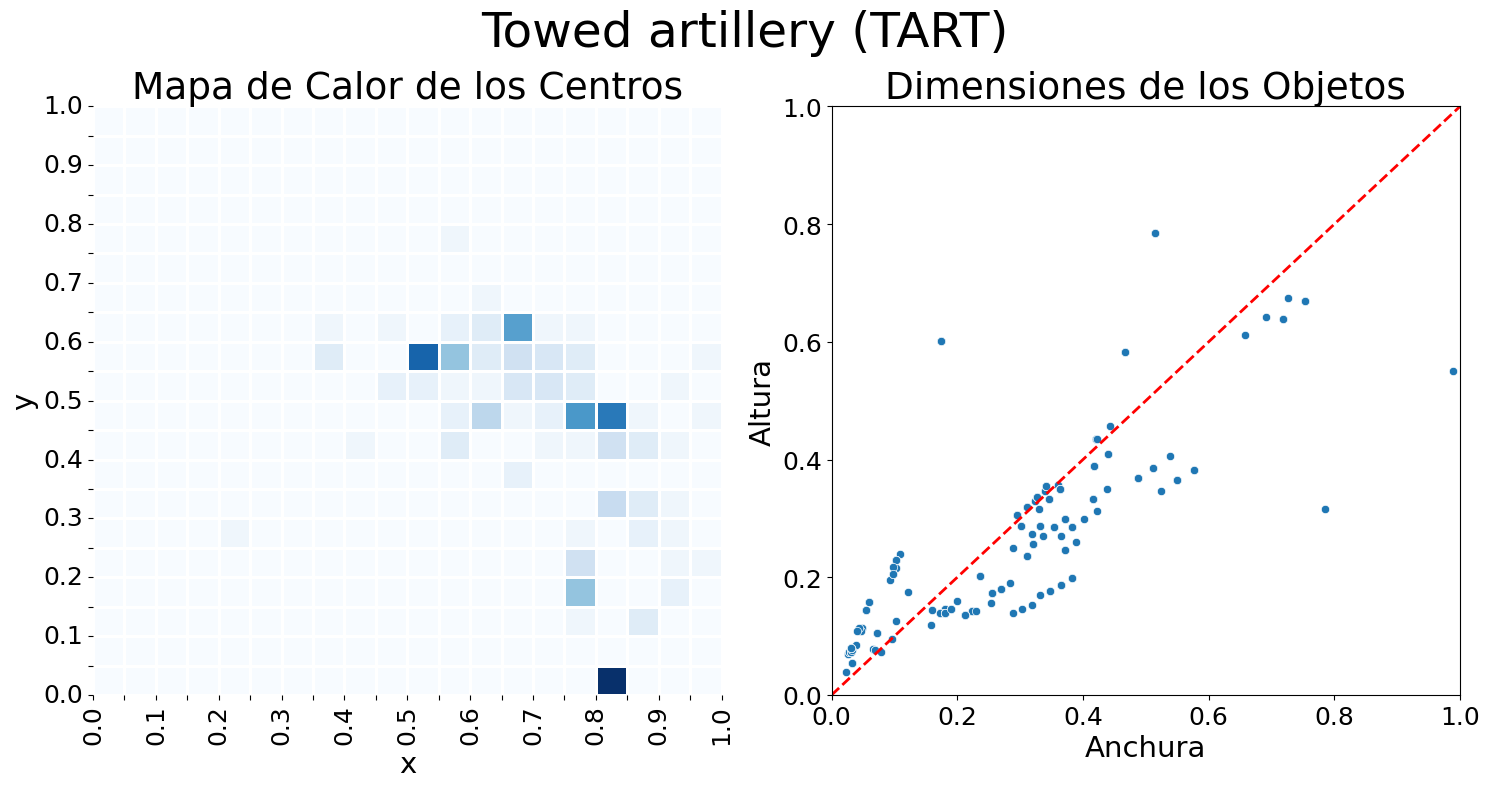

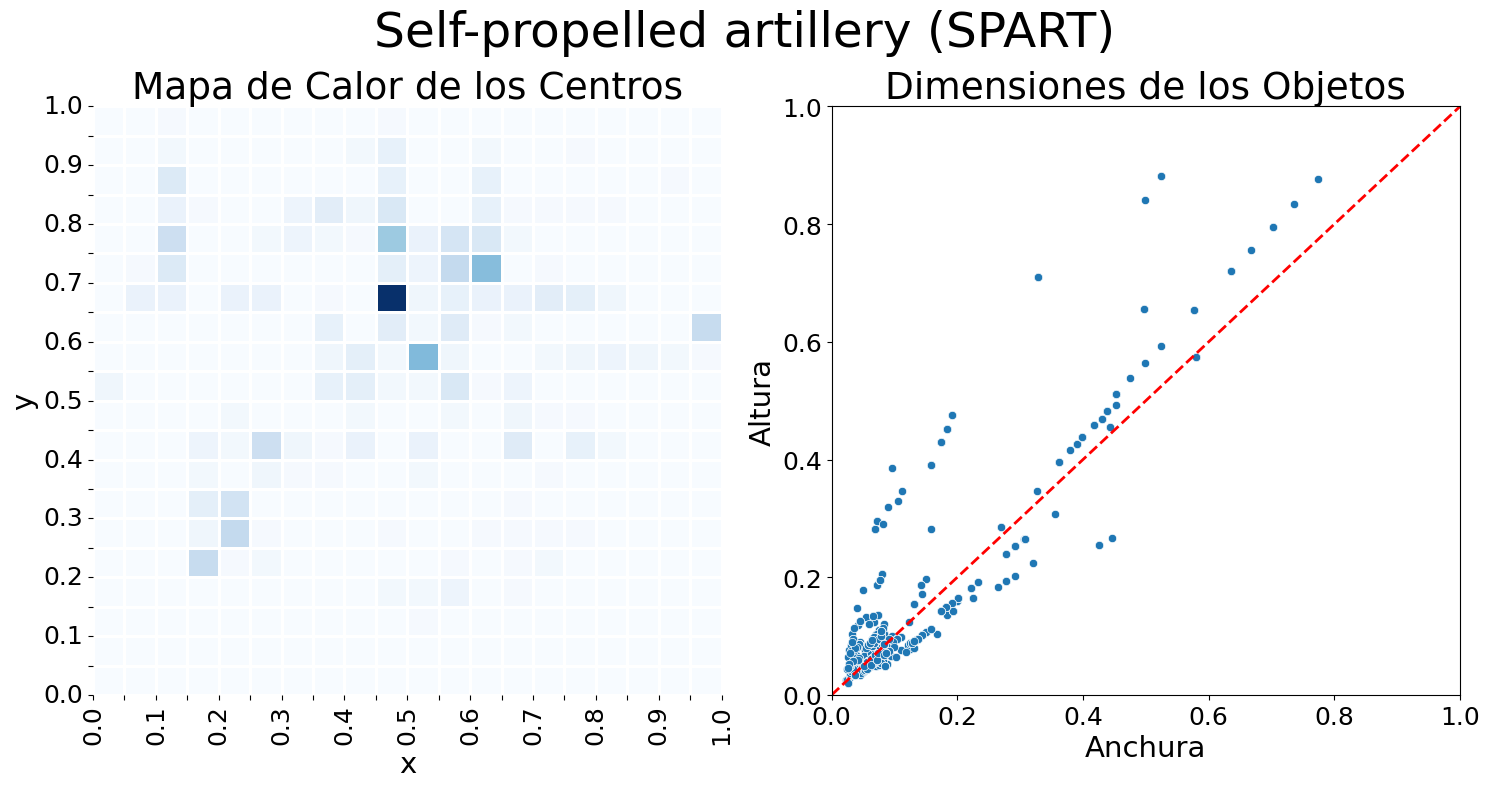

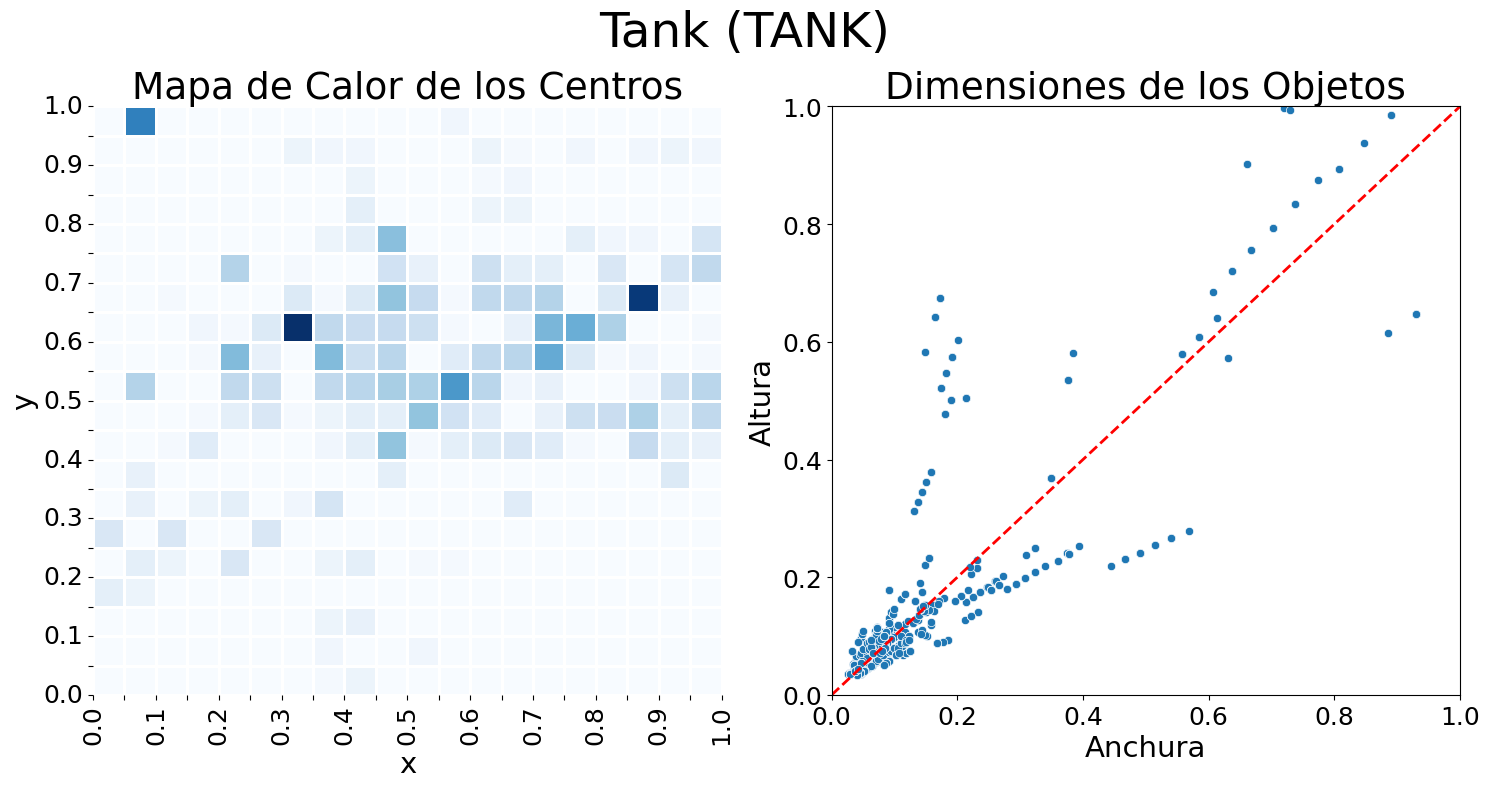

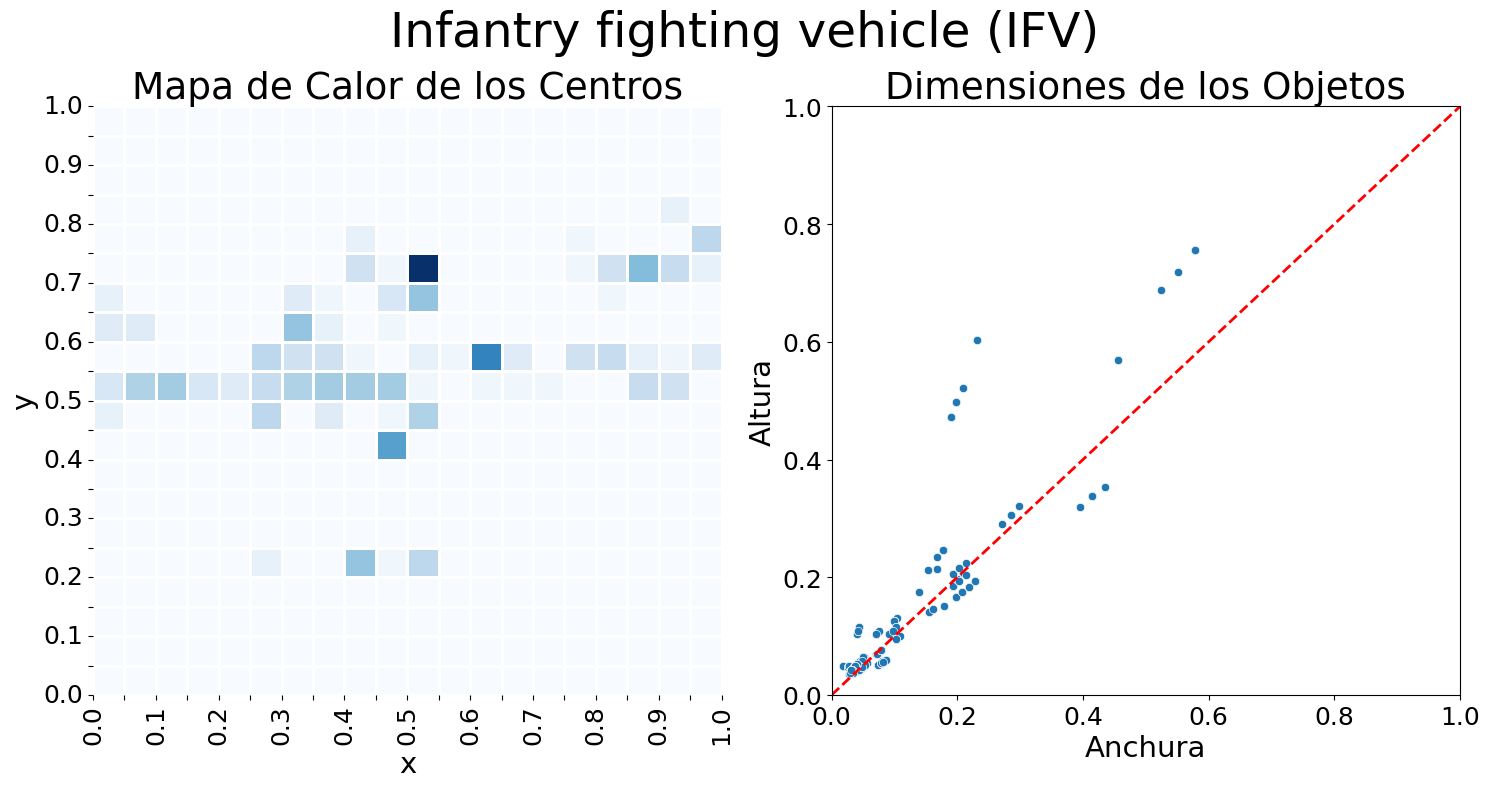

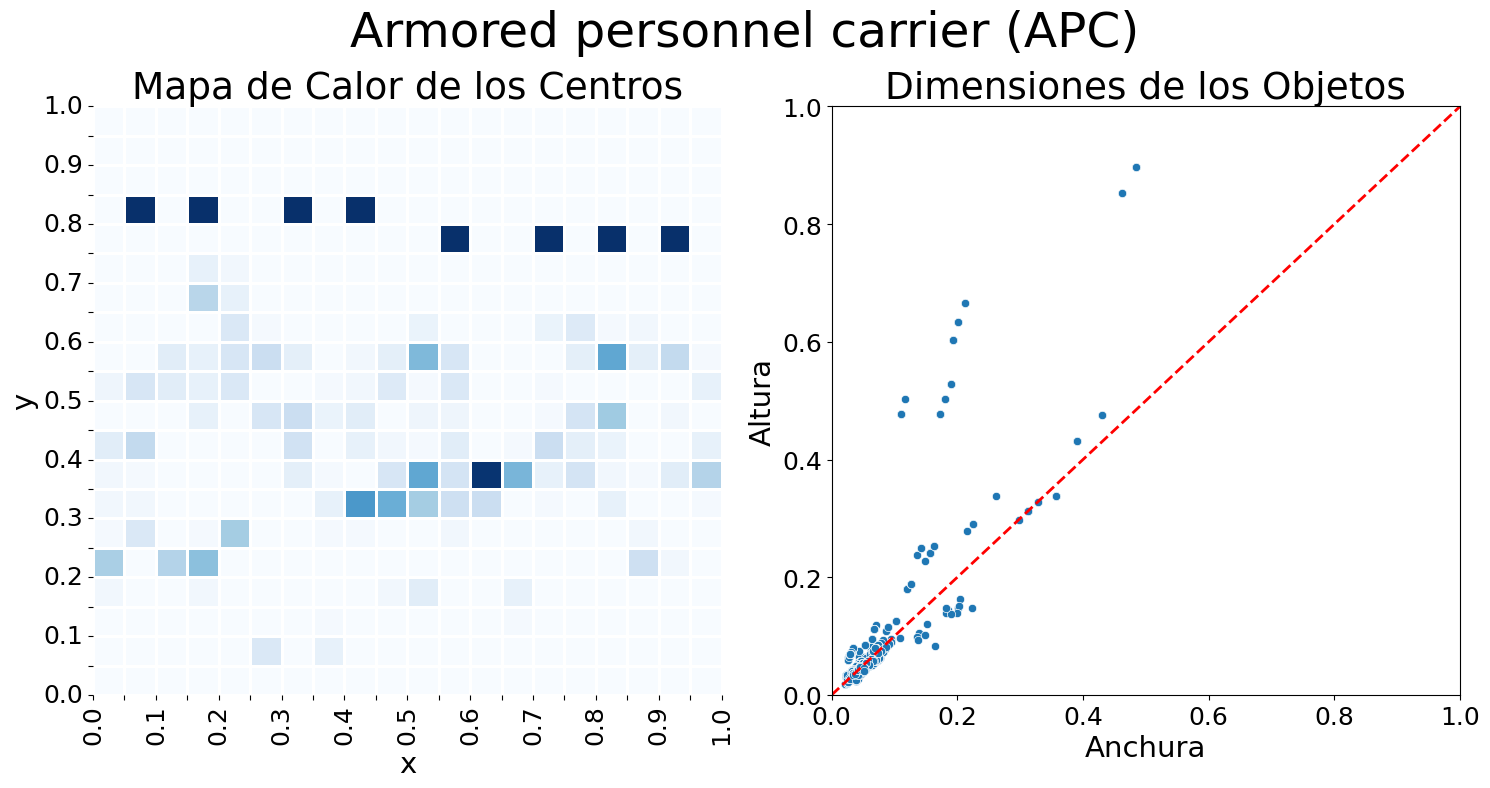

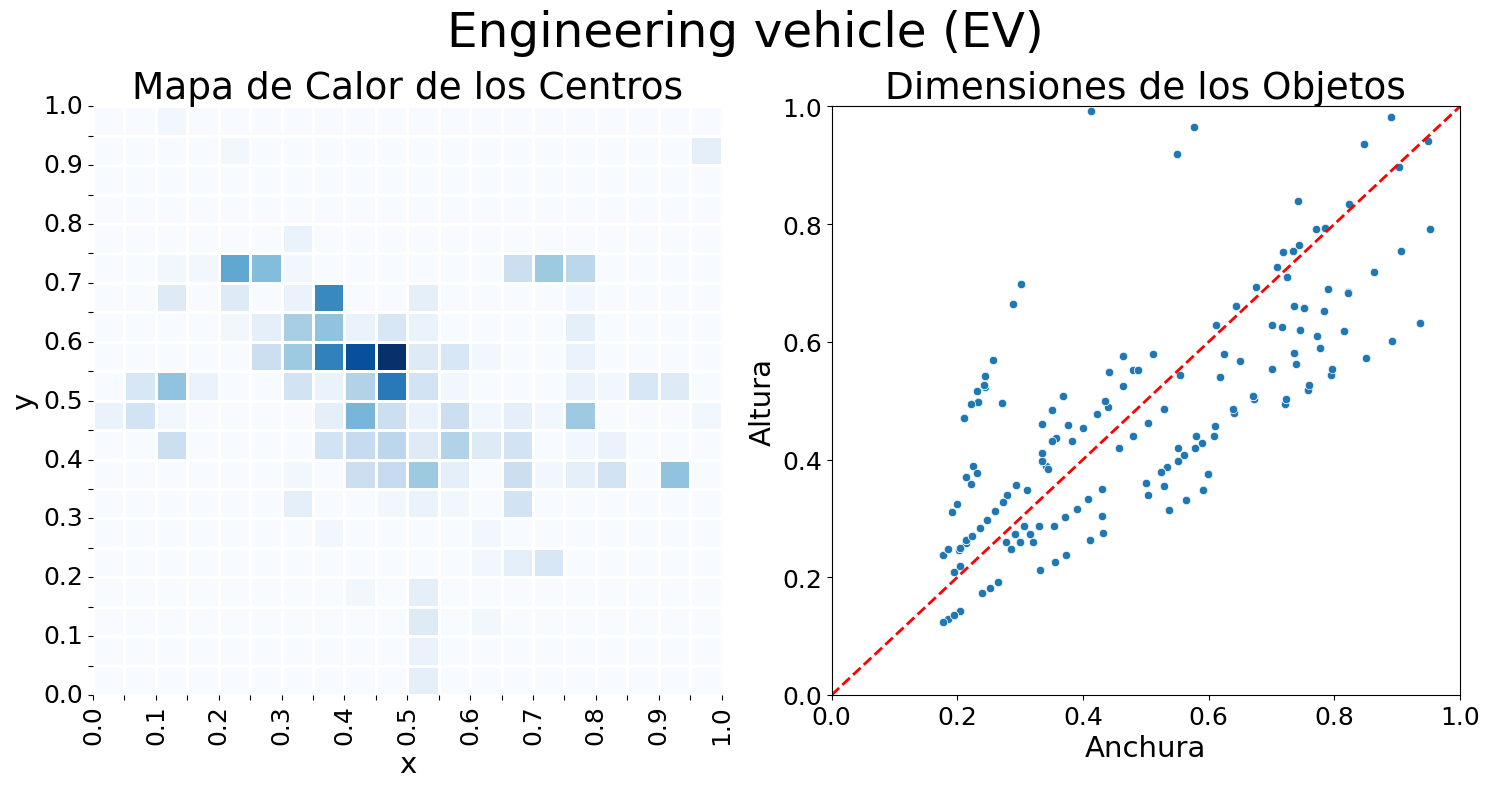

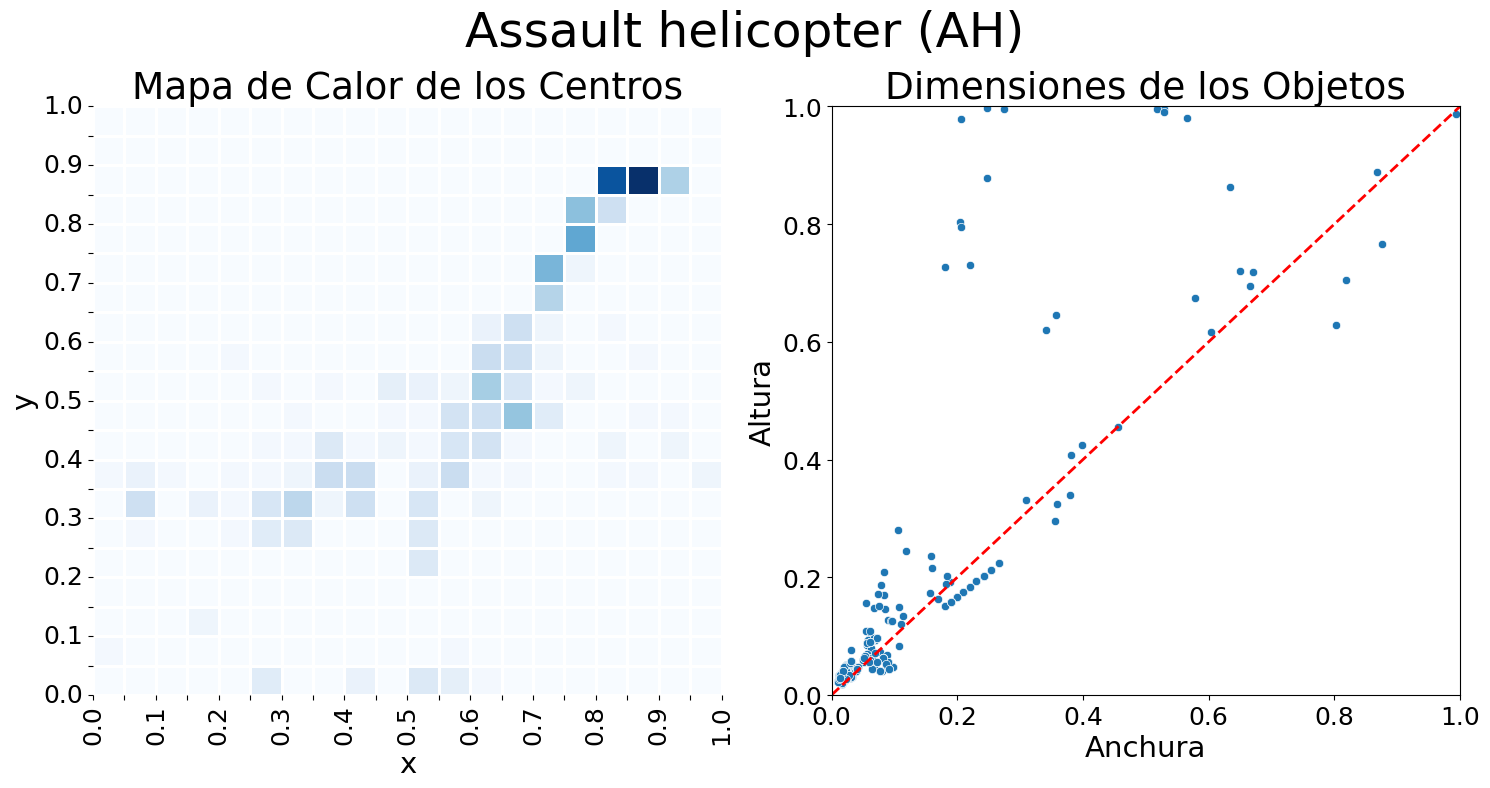

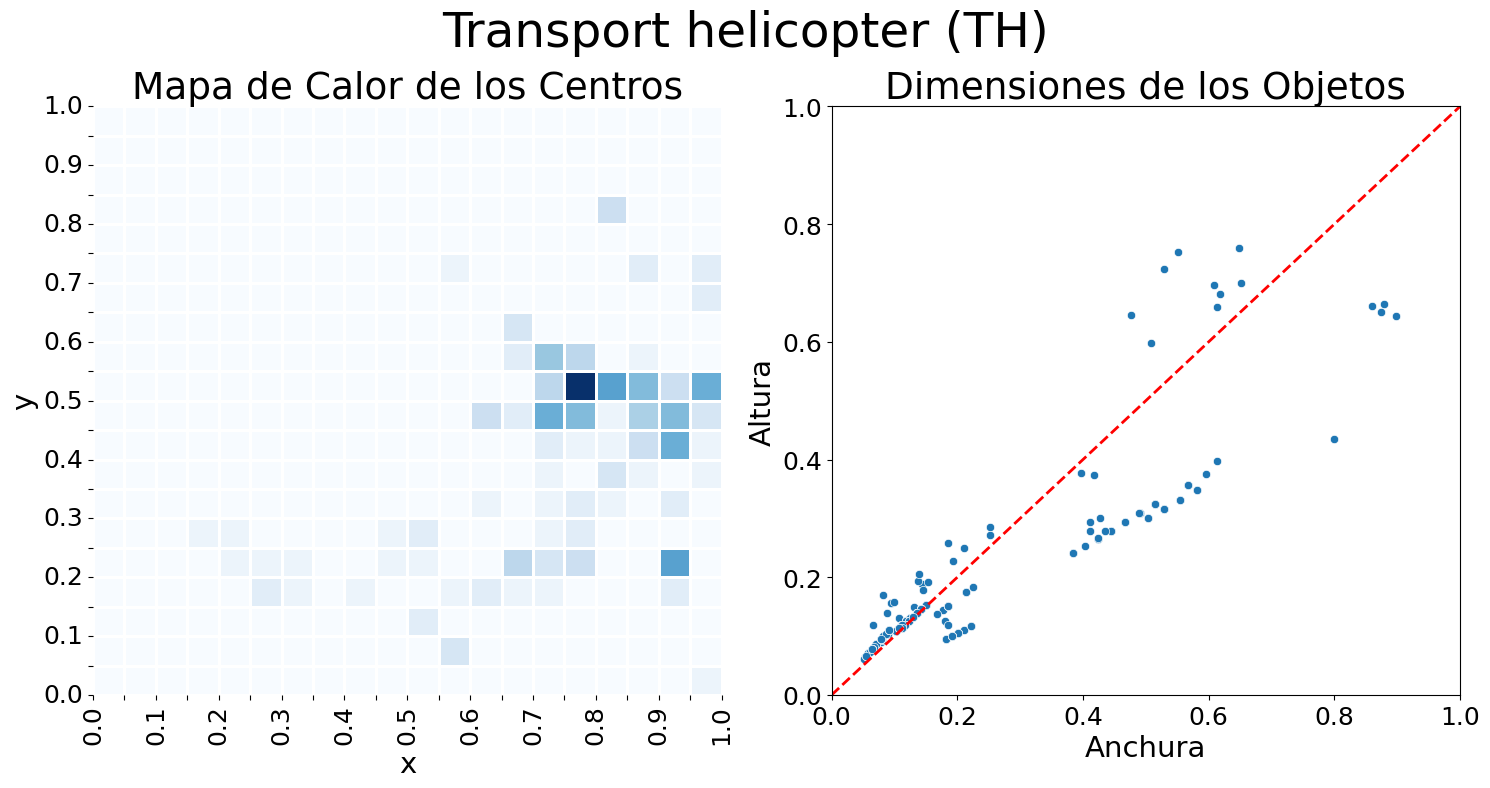

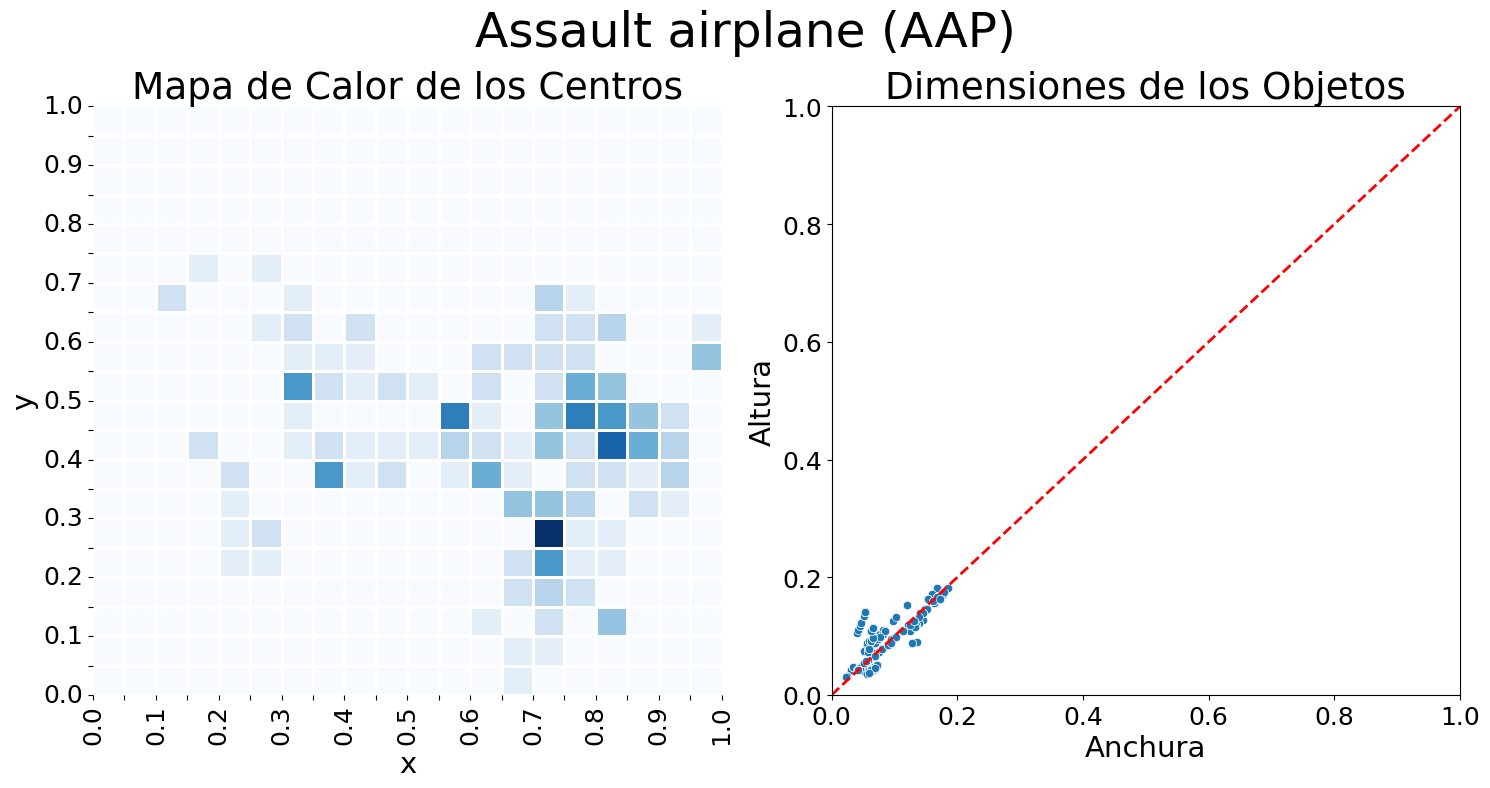

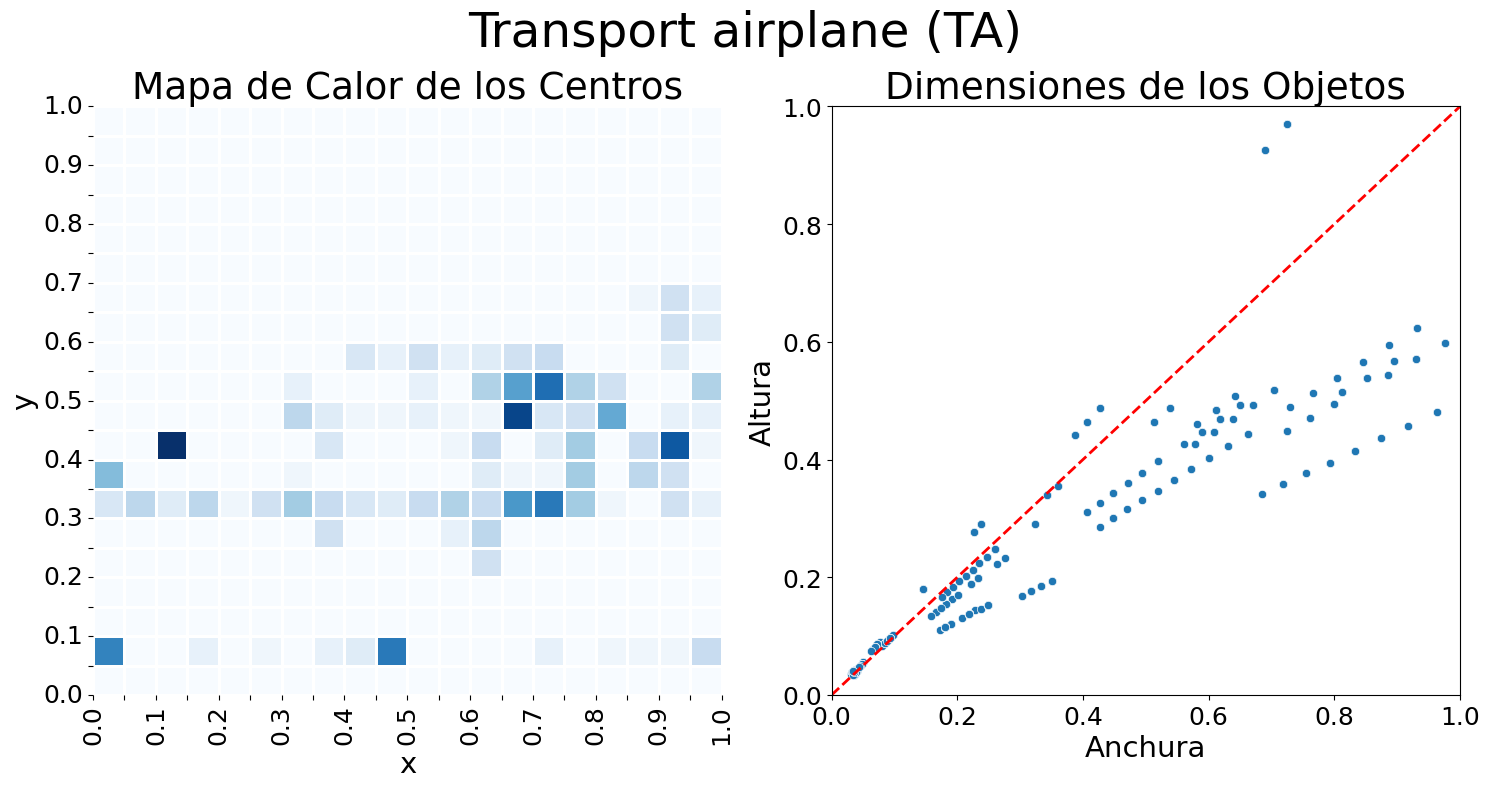

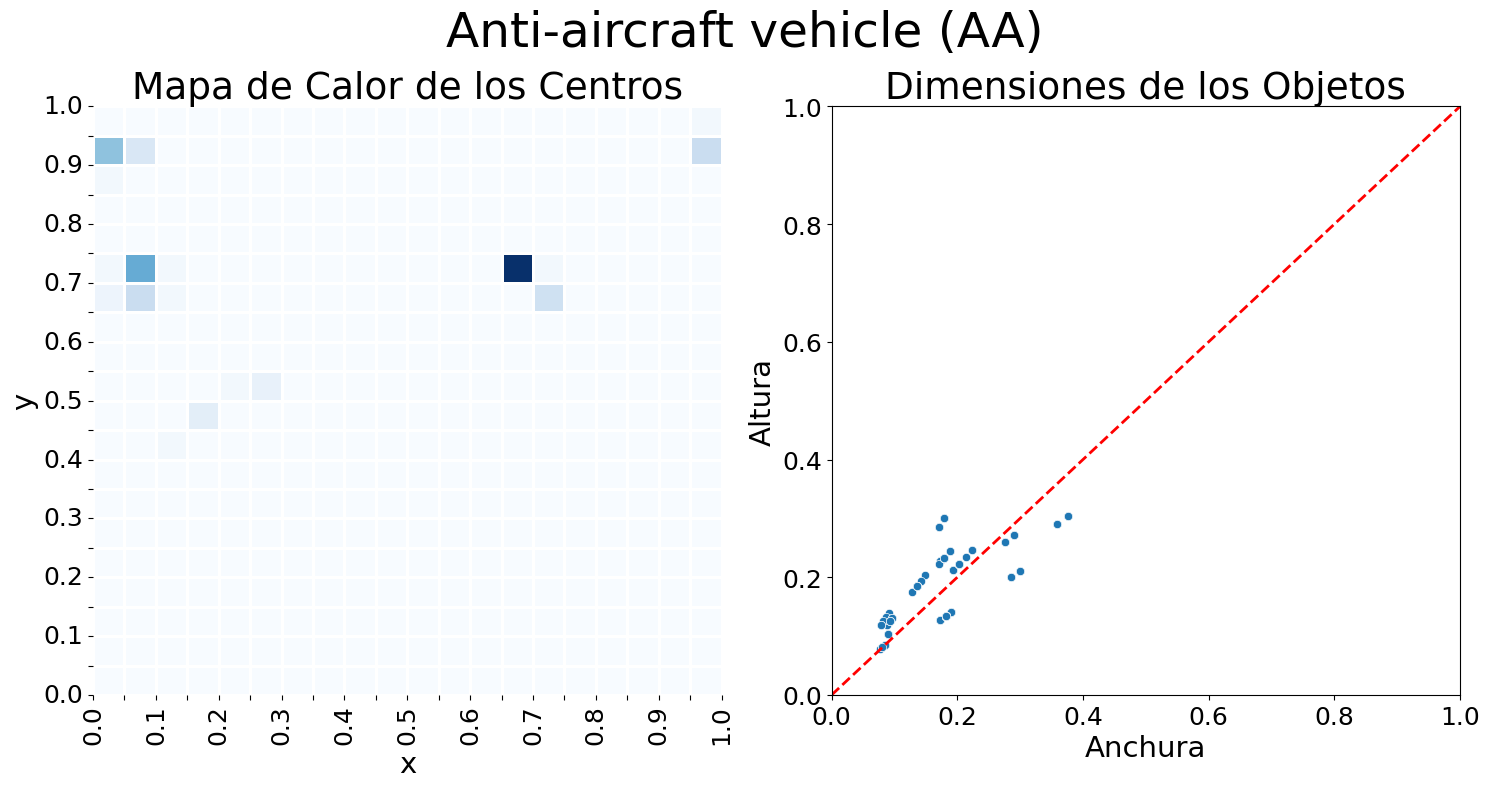

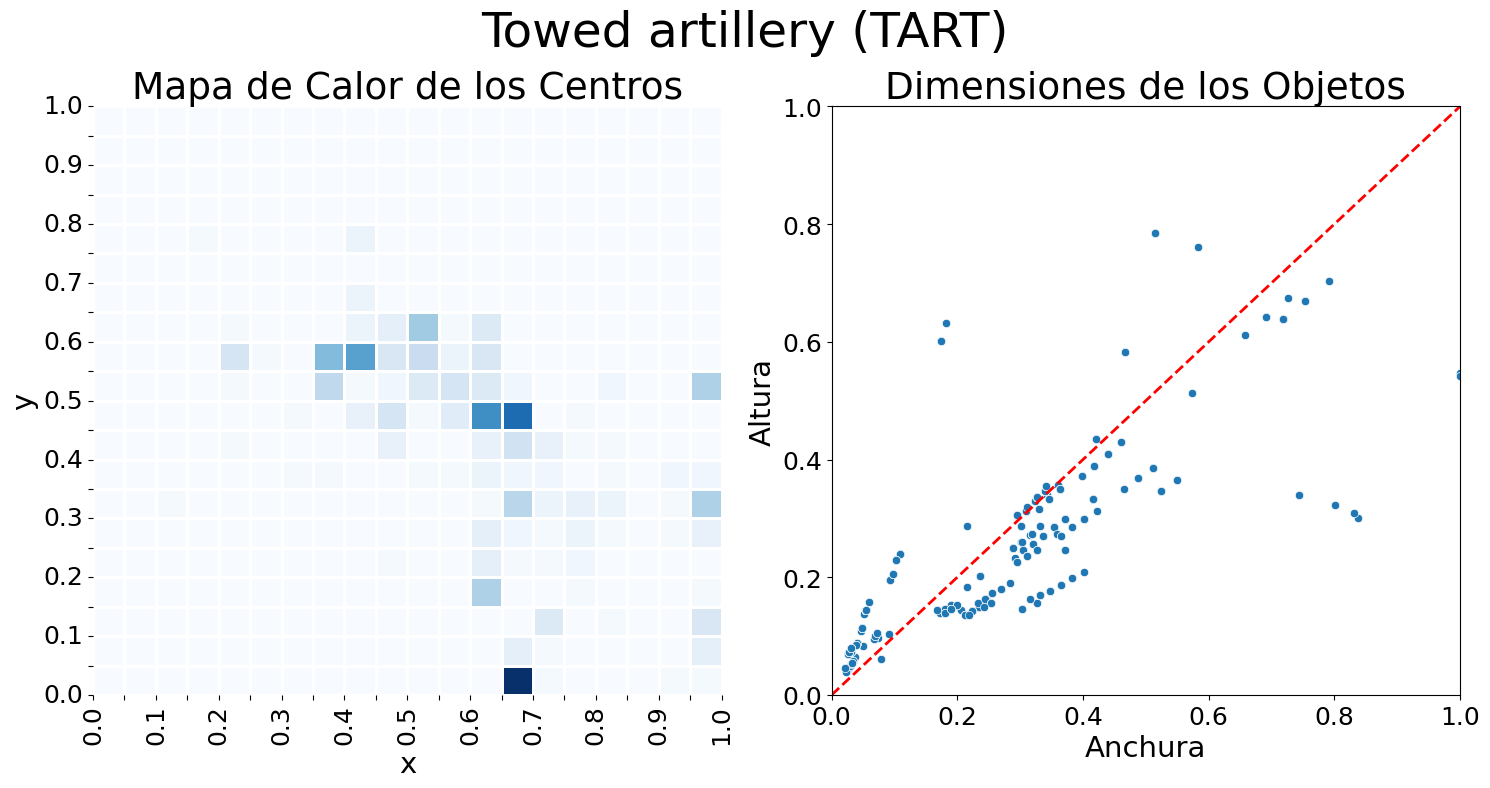

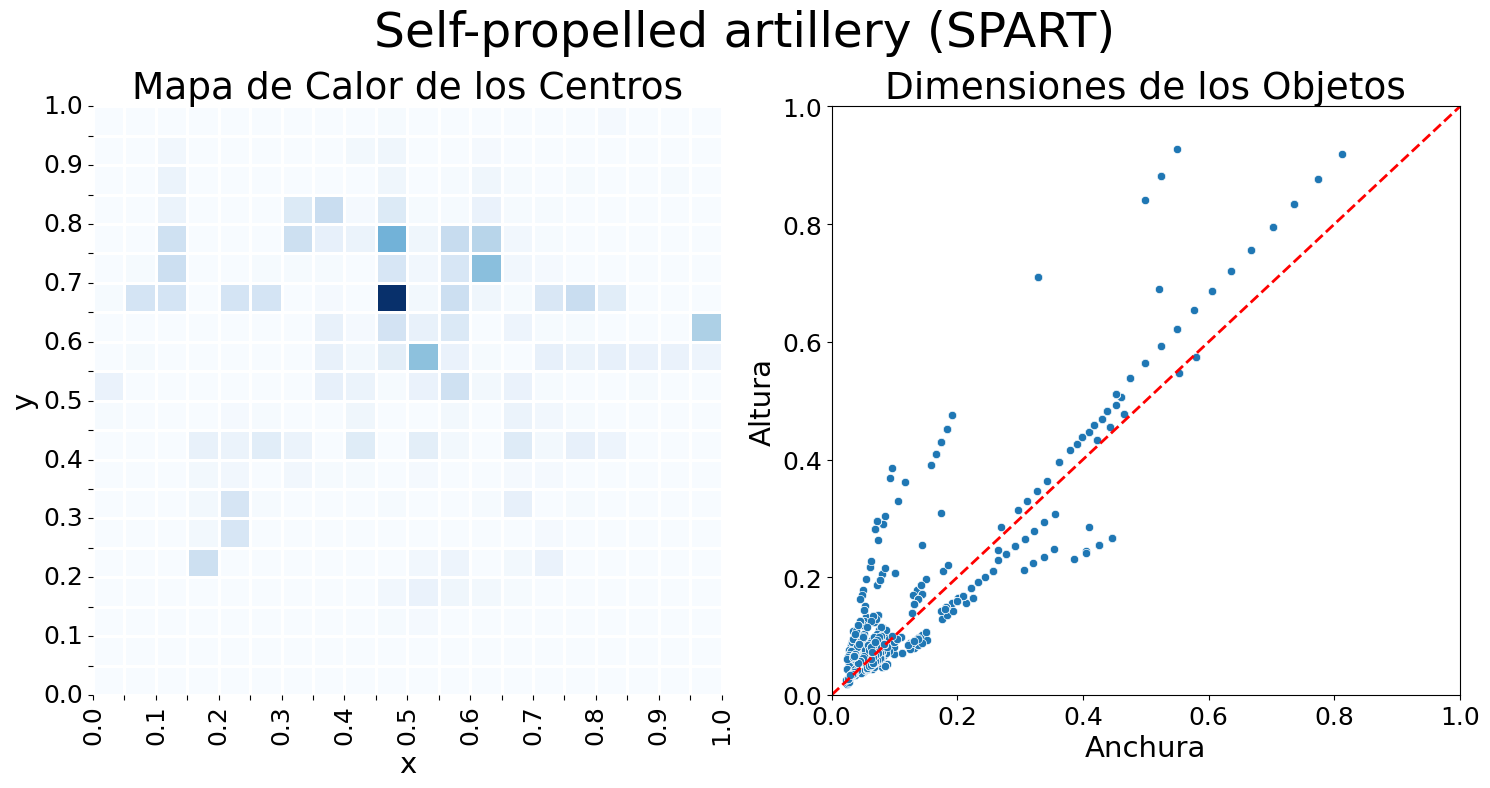

In [26]:
od_datasets = [od_train, od_val, od_test]
for i, dataset in enumerate(["train", "val", "test"]):
    for j, object_class in enumerate(OD_CLASSES):
        fig = od_plot_class(od_datasets[i], object_class)
        fig.savefig(f"plots/od_{dataset}_{j}.png", bbox_inches="tight")

## Gráficas de Segmentación Semántica

Representamos las gráficas:

Processing images: 100%|██████████| 2328/2328 [02:52<00:00, 13.52it/s]


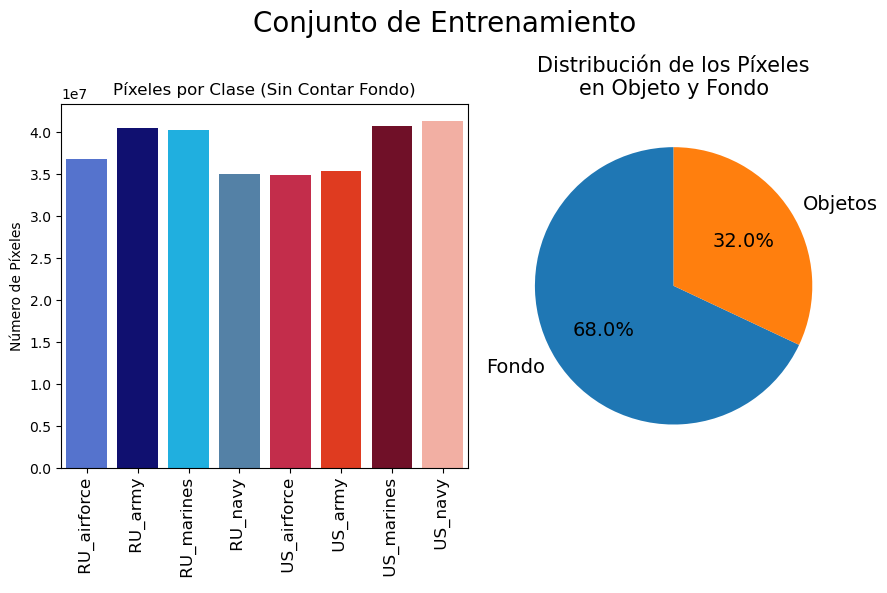

In [20]:
fig = ss_plot("datasets/ss_dataset_clean/train/", SS_CLASSES, SS_COLORS, "Conjunto de Entrenamiento")
fig.savefig("plots/ss_train.png", bbox_inches="tight")

Processing images: 100%|██████████| 220/220 [00:16<00:00, 13.59it/s]


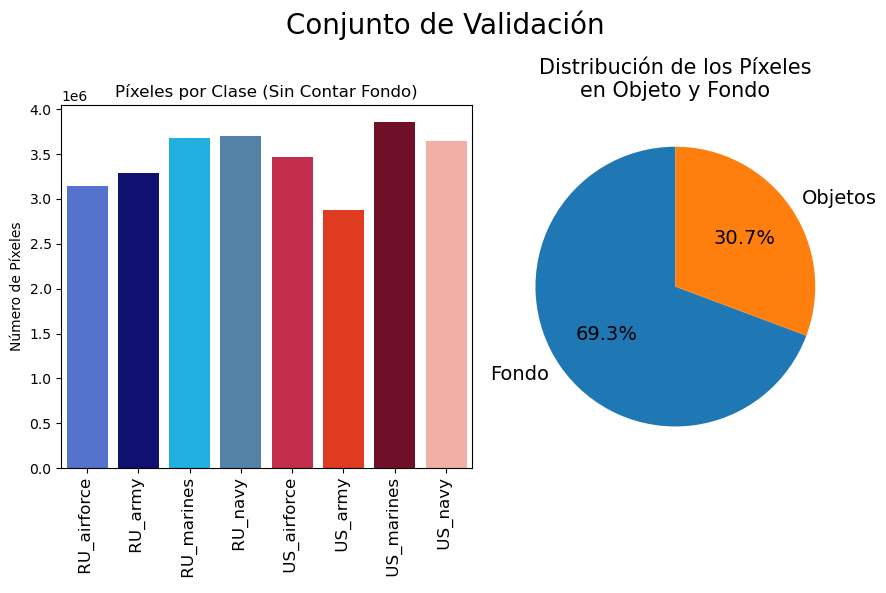

In [19]:
fig = ss_plot("datasets/ss_dataset_clean/val/", SS_CLASSES, SS_COLORS, "Conjunto de Validación")
fig.savefig("plots/ss_val.png", bbox_inches="tight")

Processing images: 100%|██████████| 104/104 [00:07<00:00, 14.63it/s]


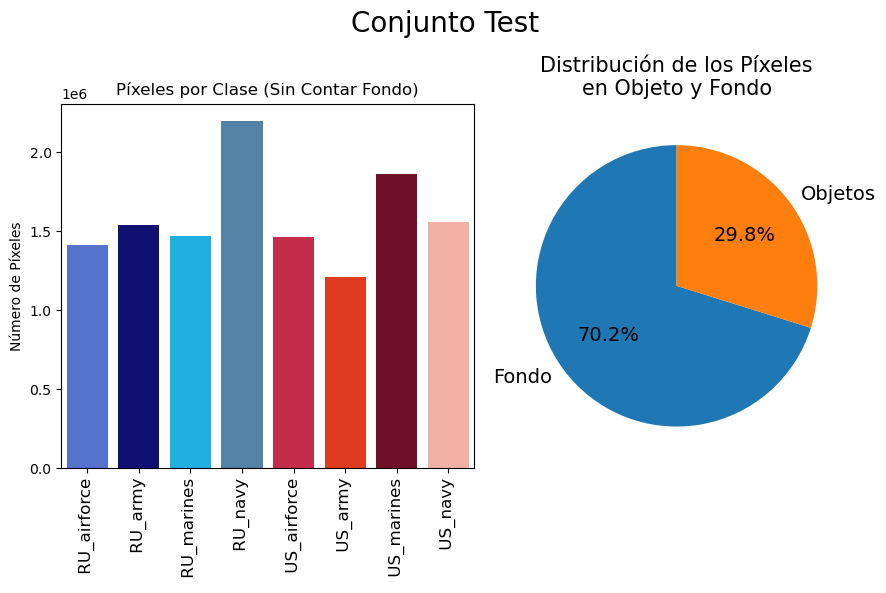

In [18]:
fig = ss_plot("datasets/ss_dataset_clean/test/", SS_CLASSES, SS_COLORS, "Conjunto Test")
fig.savefig("plots/ss_test.png", bbox_inches="tight")

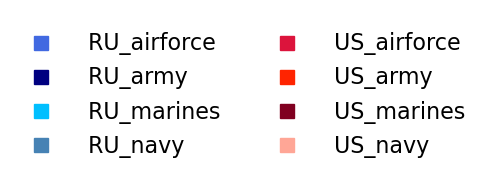

In [16]:
# Crea una figura
fig, ax = plt.subplots(figsize=(4, 2))
ax.axis("off")  # ocultar ejes

# Genera artistas proxy con plt.Line2D
proxies = [
    plt.Line2D([0], [0],
               marker='s',
               linestyle='None',
               markersize=10,
               color=col)
    for col in SS_COLORS
]

# Monta la leyenda en dos columnas
_ = ax.legend(
    handles=proxies,
    labels=list(SS_CLASSES),
    ncol=2,           # dos columnas
    frameon=False,    # sin marco
    loc='center',
    fontsize=16
)

_ = plt.tight_layout()
plt.show()

fig.savefig("plots/ss_legend.png", bbox_inches="tight")